# BL40A2020 Wireless Communication Systems

## Assignment  week 5: Optimal demodulation

## Author: Vesa Mäki

### Follow the steps done in the [Tutorial 5](https://nardelli-lut.gitbook.io/wireless-communication-systems/optimal-demodulation/m-qam-example) to analyze the *[8PSK](https://komm.readthedocs.io/en/latest/komm.PSKModulation/)* modulation

**1. Signal constelation with noise for $E_b/N_0 = 12$dB. You can reuse the code provided in this [link](https://github.com/rwnobrega/komm/blob/master/demo/constellations.ipynb), which is also available in the material provided in Azure.**

In [1]:
import numpy as np
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
from scipy.constants import Boltzmann
import matplotlib.pylab as plt
import ipywidgets
import komm
from tabulate import tabulate



In [2]:
def constellation_demo(modulation, noise_power_db, xlim, ylim):
    awgn = komm.AWGNChannel()
    num_symbols = 10000
    noise_power = 10**(noise_power_db / 10)
    awgn.signal_power = modulation.energy_per_symbol
    awgn.snr = awgn.signal_power / noise_power
    num_bits = modulation.bits_per_symbol * num_symbols
    bits = np.random.randint(2, size=num_bits)
    sentword = modulation.modulate(bits)
    recvword = awgn(sentword)
    _, ax = plt.subplots(figsize=(16, 10))
    ax.scatter(recvword.real, recvword.imag, color='xkcd:light blue', s=1)
    ax.scatter(modulation.constellation.real, modulation.constellation.imag, color='xkcd:blue', s=8**2)
    for (i, point) in enumerate(modulation.constellation):
        binary_label = ''.join(str(b) for b in komm.int2binlist(modulation.labeling[i], width=modulation.bits_per_symbol))
        ax.text(point.real, point.imag + 0.075 * xlim[0], binary_label, horizontalalignment='center')
    ax.set_title(repr(modulation))
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.axis('square')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(color='r', linestyle='--', linewidth=1)
    info_text = 'SNR = {:.1f} dB\n'.format(10*np.log10(awgn.snr))
    info_text += 'Eb/N0 = {:.1f} dB'.format(10*np.log10(awgn.snr / modulation.bits_per_symbol))
    ax.text(1.125 * xlim[1], 0.0, info_text, horizontalalignment='left', verticalalignment='center')
    plt.show()

def psk_constellation_demo(order, amplitude, phase_offset, labeling, noise_power_db):
    psk_modulation = komm.PSKModulation(order, amplitude, phase_offset, labeling)
    constellation_demo(psk_modulation, noise_power_db, xlim=[-3.0, 3.0], ylim=[-3.0, 3.0])

order_widget = ipywidgets.SelectionSlider(
#    options=[2, 4, 8, 16, 32],
    options=[8],
    continuous_update=False,
    description='Order:',
)

amplitude_widget = ipywidgets.FloatSlider(
    min=0.1,
    max=2.01,
    step=0.1,
    value=1.0,
    continuous_update=False,
    description='Amplitude:',
)

phase_offset_widget = ipywidgets.SelectionSlider(
    options=[('{:.2f}π'.format(x), np.pi*x) for x in np.arange(0.0, 2.001, step=0.01)],
    value=0.0,
    continuous_update=False,
    description='Phase offset:',
)

labeling_widget = ipywidgets.Dropdown(
    options={'Natural': 'natural', 'Reflected (Gray)': 'reflected'},
    value='reflected',
    description='Labeling:',
)

noise_power_db_widget = ipywidgets.FloatSlider(
    value=-16.8,
    min=-40.0,
    max=10.0,
    step=1.0,
    continuous_update=False,
    description='Noise power (dB):',
)

interactive_output = ipywidgets.interactive_output(
    psk_constellation_demo,
    dict(
        order=order_widget,
        amplitude=amplitude_widget,
        phase_offset=phase_offset_widget,
        labeling=labeling_widget,
        noise_power_db=noise_power_db_widget,
    ),
)

ipywidgets.VBox(
    [
        ipywidgets.HBox(
            [
                order_widget,
                amplitude_widget,
                phase_offset_widget,
                labeling_widget,
            ]
        ),
        noise_power_db_widget,
        interactive_output,
    ],
)

**2. Numerical example:** Assume the following equation:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi 600 t) - u_\mathrm{s}(t)\sin(2\pi 600 t)$$

Considering an AWGN channel so that $E_b/N_0 = 12$dB, plot the wave form for a random binary sequence of $18$ bits considering an information rate of 300 bits per second.



Wave form for a random binary sequence of 18 bits passed through
an Additive White Gaussian Noise channel
with an information rate of 300 bits/s
AWGNChannel(snr=47.863009232263856, signal_power=1.0)
Eb/N0 = 12.0 dB


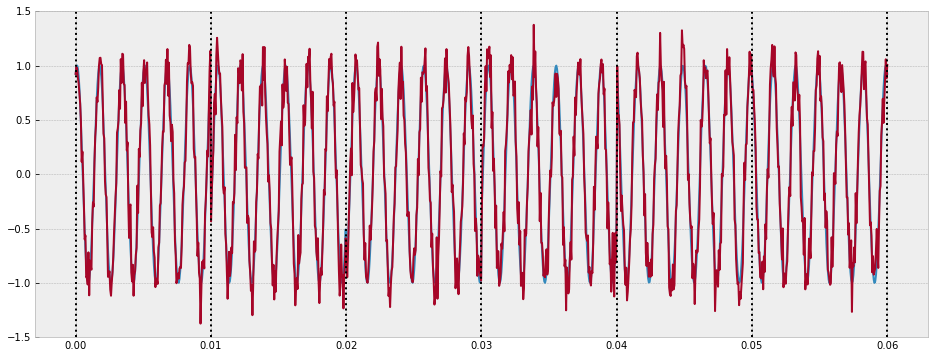

In [3]:
import math
import sympy as sp
sp.init_printing() 
import komm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

M = 8
psk8 = komm.PSKModulation(M, phase_offset=np.pi/M)

#random binary sequence
inseq_size = 18
inseq = np.random.randint(2, size=inseq_size)
#inseq = [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

input_rate = 300 # bits/s
# x-axis steps in seconds
tp = np.arange(0, inseq_size, 1)
inseq_plot = np.append(inseq, inseq[inseq_size - 1])
tp_plot = np.append(tp,tp[inseq_size-1] + 1)/input_rate
# Amount of symbols in sequence
observations = (inseq_size/np.log2(8)).astype(int)
    
#print(inseq_size)
#print(np.log2(M))
#print(np.log2(M).astype(int))
#print('Symbols')
#print(observations)
#print('Input sequence', 'length:', len(inseq))
#print(inseq)
#print('\r\n')

n_samples = 60
tmod_points = n_samples*inseq_size
tmod = np.linspace(0, tp_plot[inseq_size], tmod_points)

# Modulation of input sequence
input_wave_aux = psk8.modulate(inseq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)

for i in range(0,tmod_points):
    a = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[a],decimals=3) == np.around(psk8.constellation[j],decimals=3): 
            input_wave_I[i] = psk8.constellation[j].real 
            input_wave_Q[i] = psk8.constellation[j].imag
      
t, fc = sp.symbols('t,f_c')

modtr_I = sp.cos(2*sp.pi*fc*t)
modtr_Q = sp.sin(2*sp.pi*fc*t)

freq_c = 600
Modulator_I = sp.lambdify(t,modtr_I.subs(fc,freq_c),"numpy")
Modulator_Q = sp.lambdify(t,modtr_Q.subs(fc,freq_c),"numpy")
Modulated = input_wave_I*Modulator_I(tmod) - input_wave_Q*Modulator_Q(tmod)

awgn = komm.AWGNChannel()
num_symbols = observations
noise_power_db = -16.8
noise_power = 10**(noise_power_db / 10)
awgn.signal_power = psk8.energy_per_symbol
awgn.snr = awgn.signal_power / noise_power

S_w_noise = awgn(Modulated)

print('\r\n')
print('Wave form for a random binary sequence of 18 bits passed through')
print('an Additive White Gaussian Noise channel')
print('with an information rate of 300 bits/s')
print(awgn)
EbN0 = (10*np.log10(awgn.snr / psk8.bits_per_symbol))
print('Eb/N0 = {0:.1f} dB'.format(EbN0))
plt.rcParams['figure.figsize'] = 16, 6
plt.plot(tmod,Modulated);
plt.plot(tmod,S_w_noise);
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/input_rate,linestyle=':',color='k');
plt.ylim(-1.5,1.5);
#plt.xlim(0,0.02);
plt.show()
                   


**3. Performance analysis:** Plot the figure *error probability vs. $E_b/N_0$* assuming that the 0's and 1's in the input sequence are equally distributed. Consider two curves, symbol error probability and bit error probability.

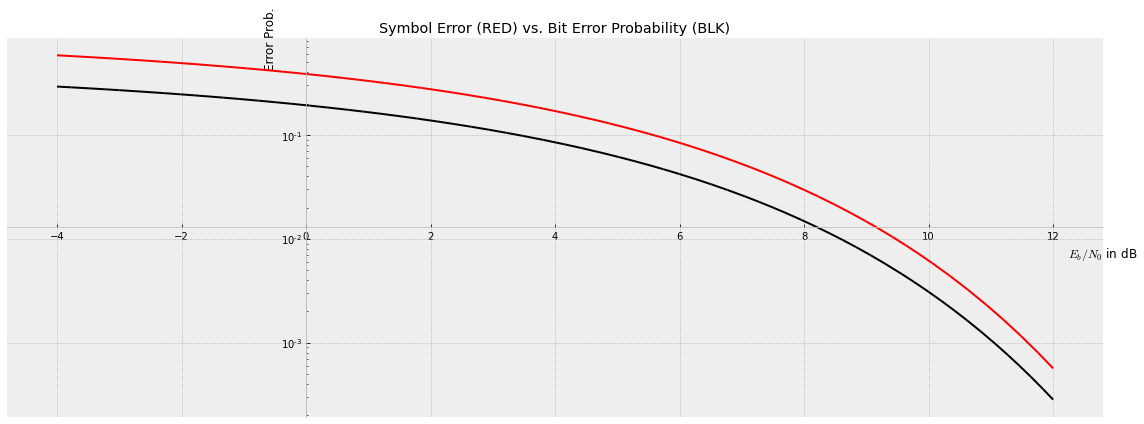

In [4]:
# Since we assume, that the 0's and 1's in the input sequence are equally
# distributed, or in other words, the distribution of input events are uniform, 
# MAP reduces to ML.

y = sp.Symbol("y")

def Q(x):
    return sp.simplify(1/2*sp.erfc(x/sp.sqrt(2)))

S_EP = sp.N(2*Q(sp.sqrt(3/4*10**(y/10)))),
B_EP = sp.N(Q(sp.sqrt(3/4*10**(y/10))))

plt.rcParams['figure.figsize'] = 16, 6
plot_EP = sp.plot(S_EP, B_EP, (y,-4,12), 
           ylabel ='Error Prob.', xlabel ='$E_b/N_0$ in dB',
           title = 'Symbol Error (RED) vs. Bit Error Probability (BLK)',       
           yscale = 'log', show = False);
plot_EP[0].line_color = 'r'
plot_EP[1].line_color = 'k'
plot_EP.show()




**4. Decision rule:** If the input sequence is not equally distributed, the optimal decision rule changes. With your own words, explain why MAP outperforms ML.

# BL40A2020 Wireless Communication Systems

## Assignment  week 6: Channel coding and information theory

## Author: Vesa Mäki

### 1. Follow similar steps done in the [Tutorial 6](https://nardelli-lut.gitbook.io/wireless-communication-systems/basics-of-channel-coding-and-information-theory) to analyze the *[Binary erasure channel](https://komm.readthedocs.io/en/latest/komm.BinaryErasureChannel/)* 

![](https://upload.wikimedia.org/wikipedia/commons/b/b6/Binary_erasure_channel.svg)

**(a) Find the analytical error probability for a repetition code with size $n$ as a function of  $p$ considering that 0 and 1 are equally distributed?**

Hint: Remember that the only way to get an error in this scenario is to have all $n$ bits in the coded block wrong.

Pr[transmit 0] = q
Pr[transmit 1] = 1-q

Pr[receive 0 | transmit 0] = 1-p
Pr[receive 1 | transmit 1] = 1-p
Pr[receive e | transmit 0] = p
Pr[receive e | transmit 1] = p
Pr[receive 0] = q * (1-p) = q - qp
Pr[receive 1] = (1-q) * (1-p) = 1 - p-q + qp
Pr[receive e] = q * p + (1-q) * p  = p

As hinted, the only way to get an error with repetition code on a BEC is to have all the bits in the block in error. So, if each bit in the n-sized block are concidered independent on the channel, then the probability of all bits being in error is P_e[bit_1] x P_e[bit_2] x P_e[bit_3] x ... x P_e[bit_n]. 

In other words, as p is the same for each bit, error probability for an n-sized block is P_e = p^n



**(b) Verify your results with simulation for a repetition code of $n=6$ and $p=0.4$.** 

Hint: You need to program/adapt the decoding. The komm decoding for repetition code is based on the Majority rule, which is not suitable for BEC.

In [5]:
# Analytical probabilities with q_ and p_ values
q_ = 0.5 
p_ = 0.4
p_t0 = q_
p_t1 = (1.0-q_)
p_r0 = q_ * (1.0-p_)
p_r1 = (1.0-q_) * (1-p_)
p_re = q_ * p_ + (1.0-q_) * p_ # = p
p_re_t0 = p_ * q_ / p_
p_re_t1 = p_ * (1-q_) / p_

# Repetition for n-times:
n_ = 6

import komm
import numpy as np
import sympy as sp
import scipy.special
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import binom

# Testing the probabilities with a sequence set
inseq_size = 10000 # test sequence size. The number of trials
# Generate input sequence the size of inseq_size, filled with 0s and 1s with
# probability of q_ for 0 and 1-q_ for 1.
inseq = np.random.choice([0, 1], size=inseq_size, p=[q_,(1-q_)])
# Create the Binary Erasure Channel, while 
# p_ is the probability of bit erasure (e)
bec = komm.BinaryErasureChannel(p_)
# Simulate passing inseq through the BEC
outseq = bec(inseq)
outseq_coded = np.zeros(inseq_size)

code_length = n_
rep_code = komm.RepetitionCode(code_length)
for i in range(inseq_size):
    coded_input = rep_code.encode(inseq[i])
    coded_bec = bec(coded_input)
#    print(coded_bec)
    whatbit = np.bincount(coded_bec)
    if np.sum(coded_bec) == code_length * 2:
        outseq_coded[i] = 2
    elif whatbit[0] > 0:
        outseq_coded[i] = 0      
    else:
        outseq_coded[i] = 1 
#    print(outseq_coded[i])

print("Simulation vs. analytical results")
print("#################")
count_uncoded = 0
count_coded = 0
# Compare original input sequence to decoded output of unrepeated and repeated inputs
for i in range(inseq_size):
    if inseq[i] != outseq[i]:
        # counter for unmatching bits in sequence of unrepeated bits
        count_uncoded = count_uncoded + 1
    if inseq[i] != outseq_coded[i]:
        # counter for unmatching bits in sequence of repeated bits
        count_coded = count_coded + 1
        
# Calculation of error probabilities
print("Probability of error uncoded:",count_uncoded/inseq_size, "Analytical:", p_)
print("Number of repetitions:", code_length)
error_coded = p_**code_length
print("Probability of error coded:",count_coded/inseq_size, "Analytical:", error_coded)


Simulation vs. analytical results
#################
Probability of error uncoded: 0.402 Analytical: 0.4
Number of repetitions: 6
Probability of error coded: 0.0037 Analytical: 0.0040960000000000015


**(c) Compute the capacity of this channel.**

Hint: $I(X;Y) = H(X) - H(X|Y) = H (X) - \sum\limits_{y={\{0,1,e\}}} p(y) H(X \; | \; Y=y)$

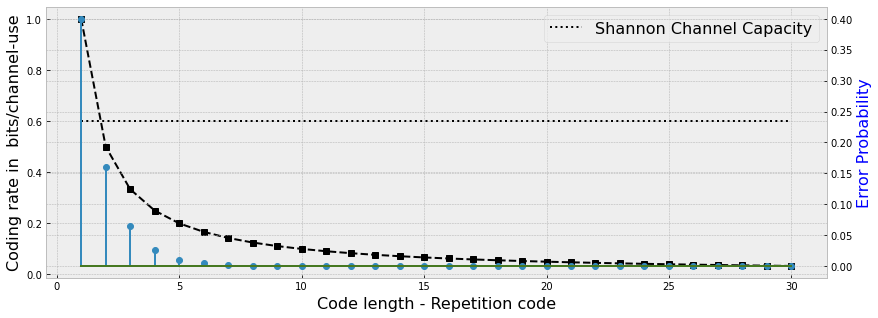

In [6]:
code_length_plot = np.arange(1,31,1)
error_coded_plot = np.zeros(len(code_length_plot))
for i in code_length_plot:
     error_coded_plot[i-1] = p_**i

fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
ax1.plot(code_length_plot, 1/code_length_plot,"ks--")
ax1.plot([1,30],[komm.BinaryErasureChannel(p_).capacity(),komm.BinaryErasureChannel(p_).capacity()] ,"k:",label='Shannon Channel Capacity')
ax2.stem(code_length_plot, error_coded_plot)
ax1.set_xlabel('Code length - Repetition code',fontsize=16)
ax1.set_ylabel('Coding rate in  bits/channel-use', color='k',fontsize=16)
ax2.set_ylabel('Error Probability', color='b',fontsize=16)
ax1.legend(fontsize=16)
plt.show()         

#error_prob = np.arange(0,1,0.01);
#capacity_bec = np.zeros(len(error_prob));
#for i in range(len(error_prob)):
#    capacity_bec[i] = komm.BinaryErasureChannel(error_prob[i]).capacity()
#plt.rcParams['figure.figsize'] = 8, 6
#plt.plot(error_prob,capacity_bec);
#plt.fill_between(error_prob, 0, capacity_bec);
#plt.xlabel('$p$',fontsize=16);
#plt.ylabel('Channel capacity',fontsize=16);
#plt.text(0.5,0.8,'Non-achievable rates',fontsize=14)
#plt.text(0.02,0.075,'Achievable rates',fontsize=14);


**(d) Discuss how good is the repetition code in relation to the capacity based on a similar plot as the one presented in the tutorial.**

The repetition code is a very wastefull in terms of capacity. Of course, adding just one repetition already halves the capacity. When error probability per bit is 40% (p = 0.4), to achieve a usefull degree of block error probability (close to zero) on the channel, at least 6 to 7 repetition bits must be used for one information bit and this drives the channel-use down to 20%.

**2. Evaluate the performance of the $M$-PSK in relation to Shannon capacity considering the symbol error probability: $$P \approx 2 Q \left(\sqrt{\dfrac{2 E_b \log_2 M}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right).$$**

**Consider the cases of $M=4,8,16$ and plot the figure $P$ versus $E_b/N_0$ in db. Additionally, plot the Shannon capacity vs. $E_b/N_0$.**

**Analyze with your own words the results.**

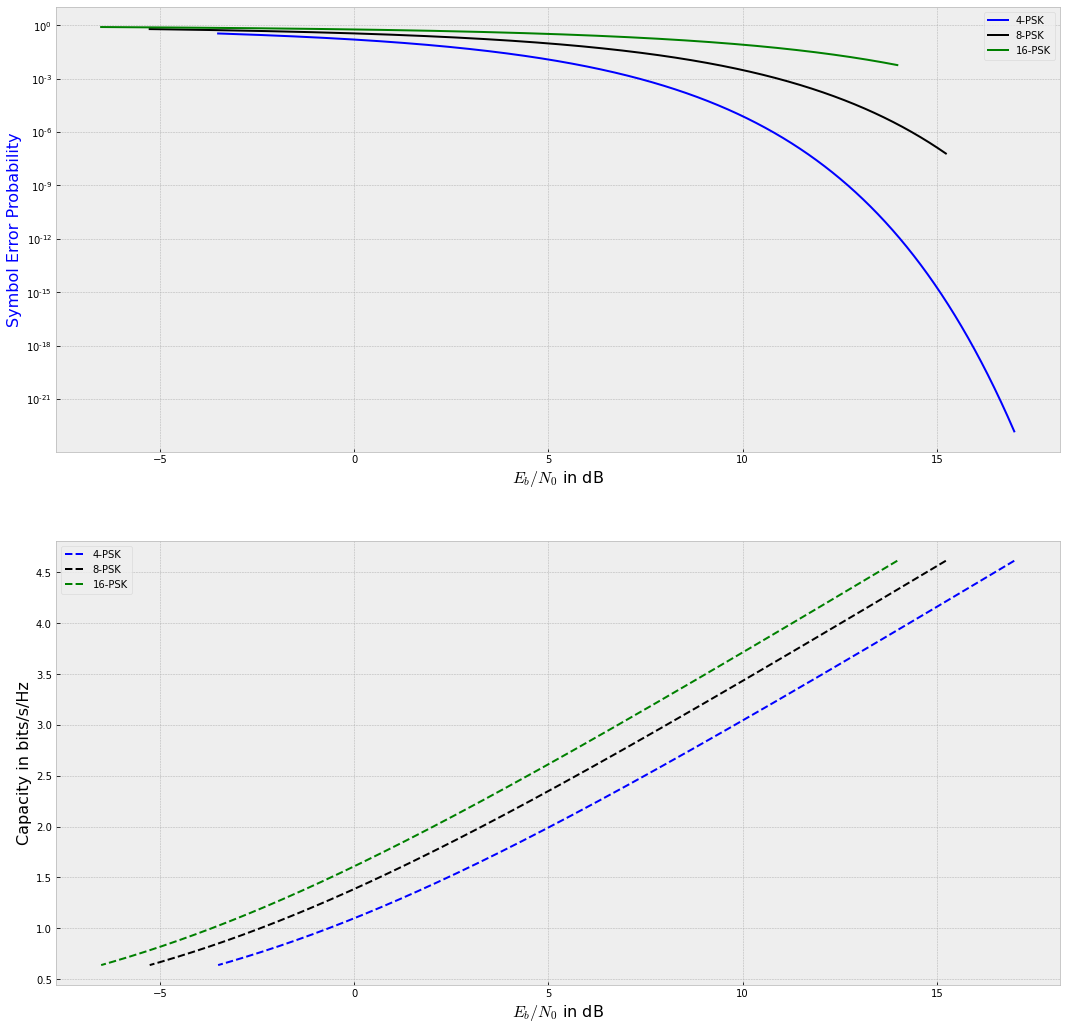

In [7]:
# An alternate way to approximate the Q-function.
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

#4-PSK
base_amplitude = 1
noise_power_db_4psk = np.arange(-20, 0.5, 0.01)
noise_power_4psk = 10**(noise_power_db_4psk / 10)
awgn = komm.AWGNChannel()
order = 4
modulation = komm.PSKModulation(order, base_amplitude, phase_offset=np.pi/order)
awgn.signal_power_4psk  = modulation.energy_per_symbol
awgn.snr_4psk  = awgn.signal_power_4psk  / noise_power_4psk
EbperN0_4psk  = awgn.snr_4psk / modulation.bits_per_symbol
error_probability_4psk  = 2*Q(np.sqrt( 2 * np.log2(order) * EbperN0_4psk) * np.sin(np.pi/order))

#8-PSK
base_amplitude = 1
noise_power_db_8psk = np.arange(-20, 0.5, 0.01)
noise_power_8psk = 10**(noise_power_db_8psk / 10)
order = 8
modulation = komm.PSKModulation(order, base_amplitude, phase_offset=np.pi/order)
awgn.signal_power_8psk  = modulation.energy_per_symbol
awgn.snr_8psk  = awgn.signal_power_8psk  / noise_power_8psk
EbperN0_8psk  = awgn.snr_8psk / modulation.bits_per_symbol
error_probability_8psk  = 2*Q(np.sqrt( 2 * np.log2(order) * EbperN0_8psk) * np.sin(np.pi/order))

#16-PSK
base_amplitude = 1
noise_power_db_16psk = np.arange(-20, 0.5, 0.01)
noise_power_16psk = 10**(noise_power_db_16psk / 10)
order = 16
modulation = komm.PSKModulation(order, base_amplitude, phase_offset=np.pi/order)
awgn.signal_power_16psk  = modulation.energy_per_symbol
awgn.snr_16psk  = awgn.signal_power_16psk  / noise_power_16psk
EbperN0_16psk  = awgn.snr_16psk / modulation.bits_per_symbol
error_probability_16psk  = 2*Q(np.sqrt( 2 * np.log2(order) * EbperN0_16psk) * np.sin(np.pi/order))

plt.figure(1,figsize=(18,18))
plt.subplot(211)
plt.semilogy(10 * np.log10(EbperN0_4psk), error_probability_4psk,'b',label='4-PSK');
plt.semilogy(10 * np.log10(EbperN0_8psk), error_probability_8psk,'k',label='8-PSK');
plt.semilogy(10 * np.log10(EbperN0_16psk), error_probability_16psk,'g',label='16-PSK');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(212)
plt.plot(10 * np.log10(EbperN0_4psk), np.log(1+awgn.snr_4psk),'--b',label='4-PSK');
plt.plot(10 * np.log10(EbperN0_8psk), np.log(1+awgn.snr_8psk),'--k',label='8-PSK');
plt.plot(10 * np.log10(EbperN0_16psk), np.log(1+awgn.snr_16psk),'--g',label='16-PSK');
plt.xlabel('$E_b/N_0$ in dB',fontsize=16);
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();


Analyze with your own words the results.

From the figures it can be seen, that firstly of course with a greater signal-to-noise -ratio, error probability is lower and better. And when error probability gets lower, capacity increases.

Lower order PSKs such as 4-PSK have lower symbol error probability, because signal power is distributed to less amount of bits and thus the bit energy-to-noise ratio is better for 4-PSK, than for 16-PSK. Each bit is transmitted with relatively more power and so noise has lesser effect. 

However, transmitting more bits per symbol, will of course increase the transmission rate, and thus capacity is increased. Therefore, given large enough signal-to-noise ratio, so that symbol error probability is kept low enough, the channel capacity is higher for 16-PSK than for 4-PSK.

# BL40A2020 Wireless Communication Systems

## Final Work

## Author: Vesa Mäki

### Part I: Exisiting technologies (30%).

Explain how a OFDM system works with your own words and based on the concepts learned in the course (this should be about two to four paragraphs). The following videos are an introduction of the techniques used in the Long-term evolution (LTE/4G) systems and will be the basis of your answer.

OFDM stands for Orthogonal Frequency Division Multiplexing, and it is a special case of FDM. OFDM method is used by many todays technologies such as Wi-Fi 802.11ac, 4G and 5G cellular technologies, WiMax and in satellite communications, to name a few. To understand OFDM, the concept of FDM has to be explaned first. In FDM, a passband frequency band dedicated to the transmission is divided into non-overlapping subchannels, each with a carrier frequency. These subcarriers are sinusoids, which are then modulated with the actual data signal. A narrow frequency band is left between subchannels to act as a "guard band" to prevent frequency overlap interference between neighboring subchannels. Different signals can then travel separately and simultaneously without interfering with each other.

OFDM on the other hand, discards the use of guard bands and also purposefully overlaps the subchannels in a specific manner, and because of this is has much better spectral efficiency. In other words, for the same amount of subchannels, OFDM requires a much smaller frequency band to divide, or can fit more subchannels to frequency band of equal size, than used with FDM. However, since the subchannels now overlap, the subchannels need to be spaced in such a way, that they don't interfere with each other. This is achived with orthogonality.

It can be said, that the signals travelling on the adjacent subchannels are orthogonal to each other, when the peak of one signal occurs at the exact frequency, while the adjacent signals are null.

![image.png](attachment:image.png)

For current LTE wireless networks, the main passband carrier frequencies are in the range of some hundreds of megahertz to a few gigahertz. For OFDM with n-amount of subchannels, the subchannels are divided around the positive and negative sides of passband carrier frequency with 15kHz spacing so that the first subchannel is at $\pm 15$ kHz and the last $\pm 15 * n/2$ kHz. In other words, the subcarriers are harmonics of 15kHz. We can talk about negative frequencies, because the main carrier is a passband frequency. The amount of subcarriers is dependent on the amount of bandwidth reserved for the main carrier band. 

To transmit data, the subcarrier sinusoids are modulated with modulation symbols with constellations that represent digital modulation schemes, such as QPSK and Mth order QAMs. The symbol duration on all subcarriers is always $66.7 \mu s$, which means, that as they are harmonous to each other, all subcarriers have a whole number of cycles per one symbol duration. This symbol duration of the subcarrier sinusoid can be thought of as a slot during which each symbol of the used modulation scheme is tranmitted. The phase and amplitude are adjusted accordingly to the constellation of the modulation used.

Before the actual data can be sent, to reduce hardware complexities the parallel subcarrier signals on the frequency domain are converted using Inverse Fast Fourier Transform (IFFT, a DSP technique) to samples of a composite time domain signal. This signal is much easier generate in HW. Lastly, the signal is converted to an analog signal and modulated at the desired passband radio frequency to be transmitted as radio waves over the air.

At the receiving end, all the above steps are reversed to present the original data. Finally, it should be noted as well, that OFDM is high in power comsumption, because the IFFT summation of the paraller subcarriers causes a high peak to average power ratio. Therefore, OFDM can only be used for downlink data on mobile devices.

In [8]:
import math
import komm
import sympy as sp
sp.init_printing() 
import numpy as np
from sympy.stats import Normal, density, E, std, cdf 
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import scipy.special
from scipy.stats import binom
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

### Part II: Tasks in Jupyter 

**1 (20%).** Modulating pulses.  Select and plot in time and frequency one example of modulating pulses (signals) that are:

**(a) Time-limited**

A pulse, that is limited in its duration in time. I.e. signal value is zero at all other times, but at 1 second. This pulse is time limited to last for 1 seconds. Time-limited signals cannot be band limited.

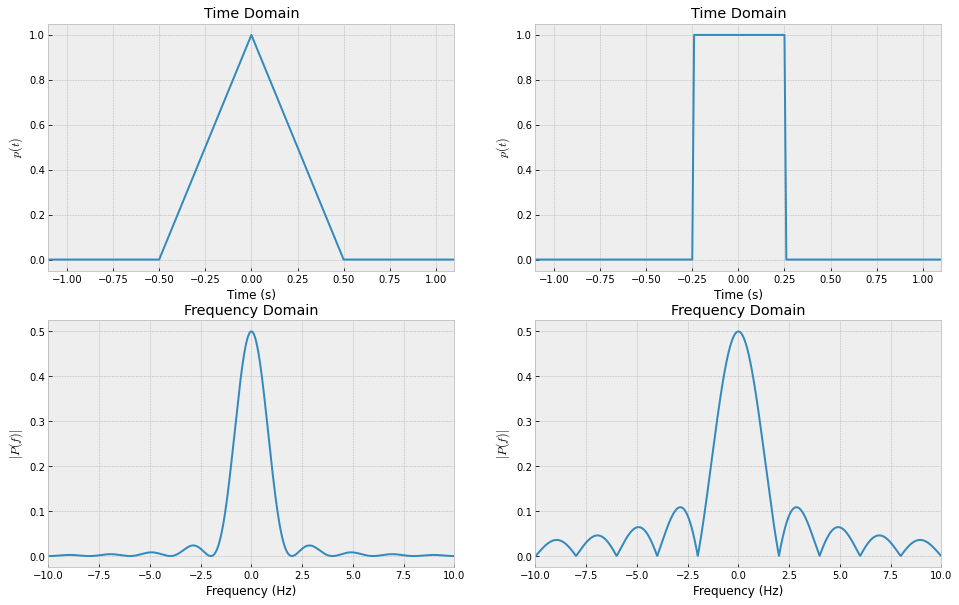

In [9]:
fs = 100 # sampling rate in Hz

t = np.arange(-10,10,1/fs)
T0 = 1 # width of the base of the pulse

plt.figure(figsize=(16, 10))

### Time limited Triangular-pulse
x1 = ss.tri(t,T0/2)
plt.subplot(221)
plt.plot(t,x1);
#ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');

### Time limited Rectangular-pulse
x2 = ss.rect(t,T0/2)
plt.subplot(222)
plt.plot(t,x2);
#ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');

### Time limited Triangular-pulse
f,X1 = ss.ft_approx(x1,t,4096)
plt.subplot(223)
plt.plot(f,abs(X1));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');

### Time limited Rectangular-pulse Fourier-transform
f,X2 = ss.ft_approx(x2,t,4096)
plt.subplot(224)
plt.plot(f,abs(X2));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');



**(b) Band-limited**

A signal, that is restricted to have power on only certain frequencies. A band limited signal, which appears rectangular on the frequency domain plot, becomes as a sinc pulse on the time domain.

ps. Signals that might be considered: step, retangular, sinc, triangular, sine, cosine, ...

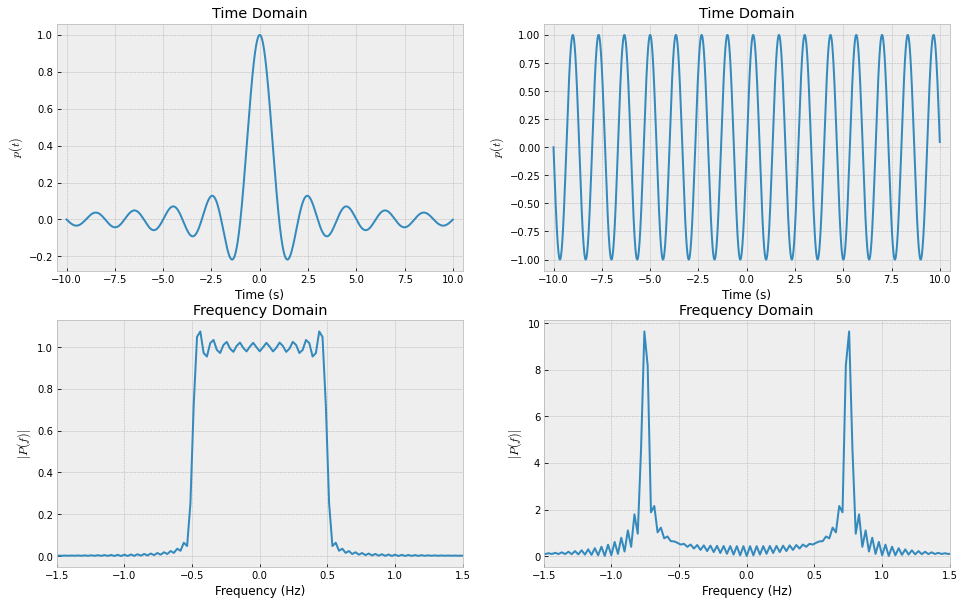

In [10]:
fs = 100 # sampling rate in Hz
t = np.arange(-10,10,1/fs)
T0 = 1 # width of the base of the pulse

plt.figure(figsize=(16, 10))

### Sinc-pulse
x1 = np.sinc(t)
plt.subplot(221)
plt.plot(t,x1);
#ylim([-1.1,1.1])
plt.xlim([-10.5,10.5])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');

### Sin-signal
x2 = np.sin(2*np.pi*0.75*t)
plt.subplot(222)
plt.plot(t,x2);
#ylim([-1.1,1.1])
plt.xlim([-10.5,10.5])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');

### Sinc-pulse Fourier-transform becomes a limited band in frequency domain
f,X1 = ss.ft_approx(x1,t,4096)
plt.subplot(223)
plt.plot(f,abs(X1));
plt.title(r'Frequency Domain')
plt.xlim([-1.5,1.5])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');

### Sin-signal Fourier-transform peaks at frequency of the sin-wave and
### the frequency occupancy is limited.
f,X2 = ss.ft_approx(x2,t,4096)
plt.subplot(224)
plt.plot(f,abs(X2));
plt.title(r'Frequency Domain')
plt.xlim([-1.5,1.5])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');

**2 (50%).** Compare the performance in terms of **symbol error probability** of 2-PAM, 4-PAM, 4-QAM, 16-QAM, 64-QAM, 4-PSK, 8-PSK and 16-PSK in an AWGN channel with mean 0 and variance sigma = N_0/2 (per dimension). Considering that they have the **same average symbol energy ($E_s = 1$**, which is different from assignment). You can refer to [this text](http://www2.ensc.sfu.ca/people/faculty/ho/ENSC805/c4p2a.pdf) to find the equations of the symbol-error probability (remember to use the inequalities as approximations).

In [11]:
# An alternate way to approximate the Q-function.
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

**(a)** Plot the SNR in dB vs. Symbol error probability for these values. Note that $SNR = E_s/N_0$.

class AWGNChannel(snr=inf, signal_power=1.0)
Additive white gaussian noise (AWGN) channel. It is defined by $Y_n=X_n+Z_n$,
where $X_n$ is the channel input signal, $Y_n$ is the channel output signal, 
and $Z_n$ is the noise, which is i.i.d. according to a gaussian distribution 
with zero mean. The channel signal-to-noise ratio is calculated by $SNR = P/N$,
where $P = E[X_n^2]$ is the average power of the input signal, and $N = E[Z_n^2]$ 
is the average power (and variance) of the noise.

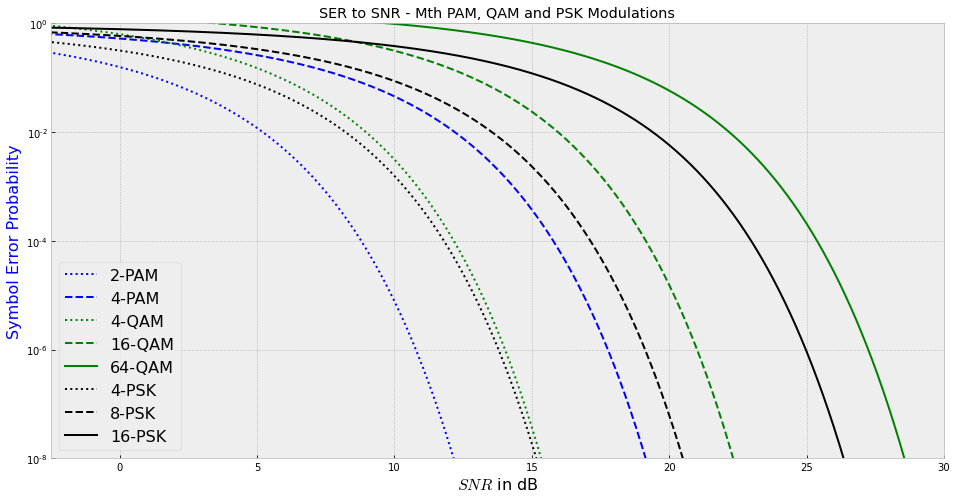

In [12]:
# Fixed problems from updates to komm. Commented as old.

#base_amplitude = 1
noise_power_db = np.arange(-30, 2.5, 0.01)
noise_power = 10**(noise_power_db / 10)
awgn = komm.AWGNChannel(signal_power=1.0)
#awgn.snr = awgn.signal_power / noise_power # Old
awgn_snr = []
#for i in noise_power:
#    snr.append(awgn.signal_power / i)
[awgn_snr.append(awgn.signal_power / i) for i in noise_power]

#2-PAM
order = 2
#ser_prob_2pam  = 2*Q(np.sqrt((6 / (order**2-1)) * awgn.snr)) # Old
ser_prob_2pam = []
[ser_prob_2pam.append(2*Q(np.sqrt((6 / (order**2-1)) * i))) for i in awgn_snr]
    
#4-PAM
order = 4
#ser_prob_4pam  = 2*Q(np.sqrt((6 / (order**2-1)) * awgn.snr)) # Old
ser_prob_4pam = []
[ser_prob_4pam.append(2*Q(np.sqrt((6 / (order**2-1)) * i))) for i in awgn_snr]    

#4-QAM
order = 4
#ser_prob_4qam  = 4*Q(np.sqrt( (3 / (order - 1)) * awgn.snr)) # Old
ser_prob_4qam = []
[ser_prob_4qam.append(4*Q(np.sqrt( (3 / (order - 1)) * i))) for i in awgn_snr]    
    
#16-QAM
order = 16
#ser_prob_16qam  = 4*Q(np.sqrt( (3 / (order - 1)) * awgn.snr)) # Old
ser_prob_16qam = []
[ser_prob_16qam.append(4*Q(np.sqrt( (3 / (order - 1)) * i))) for i in awgn_snr]

#64-QAM
order = 64
#ser_prob_64qam  = 4*Q(np.sqrt( (3 / (order - 1)) * awgn.snr)) # Old
ser_prob_64qam = []
[ser_prob_64qam.append(4*Q(np.sqrt( (3 / (order - 1)) * i))) for i in awgn_snr]

#4-PSK
order = 4
#ser_prob_4psk  = 2*Q(np.sqrt( 2 * awgn.snr) * np.sin(np.pi/order)) # Old
ser_prob_4psk = []
[ser_prob_4psk.append(2*Q(np.sqrt( 2 * i) * np.sin(np.pi/order))) for i in awgn_snr]

#8-PSK
order = 8
#ser_prob_8psk  = 2*Q(np.sqrt( 2 * awgn.snr) * np.sin(np.pi/order)) # Old
ser_prob_8psk = []
[ser_prob_8psk.append(2*Q(np.sqrt( 2 * i) * np.sin(np.pi/order))) for i in awgn_snr]

#16-PSK
order = 16
#ser_prob_16psk  = 2*Q(np.sqrt( 2 * awgn.snr) * np.sin(np.pi/order)) # Old
ser_prob_16psk = []
[ser_prob_16psk.append(2*Q(np.sqrt( 2 * i) * np.sin(np.pi/order))) for i in awgn_snr]

# Plots
plt.figure(1,figsize=(16,8))
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_2pam,':b',label='2-PAM'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_2pam,':b',label='2-PAM');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_4pam,'--b',label='4-PAM'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_4pam,'--b',label='4-PAM');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_4qam,':g',label='4-QAM'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_4qam,':g',label='4-QAM');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_16qam,'--g',label='16-QAM'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_16qam,'--g',label='16-QAM');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_64qam,'g',label='64-QAM'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_64qam,'g',label='64-QAM');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_4psk,':k',label='4-PSK'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_4psk,':k',label='4-PSK');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_8psk,'--k',label='8-PSK'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_8psk,'--k',label='8-PSK');
#plt.semilogy(10 * np.log10(awgn.snr), ser_prob_16psk,'k',label='16-PSK'); # Old
plt.semilogy(10 * np.log10(awgn_snr), ser_prob_16psk,'k',label='16-PSK');
plt.ylim([1e-8,1e-0])
plt.xlim([-2.5,30])
plt.xlabel('$SNR$ in dB',fontsize=16);
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.title(r'SER to SNR - Mth PAM, QAM and PSK Modulations')
plt.legend(fontsize=16, loc='lower left');

**(b)** Compare these modulations in relation to the trade-off involved between spectral efficiency (bits/s/Hz) and bit error probability.

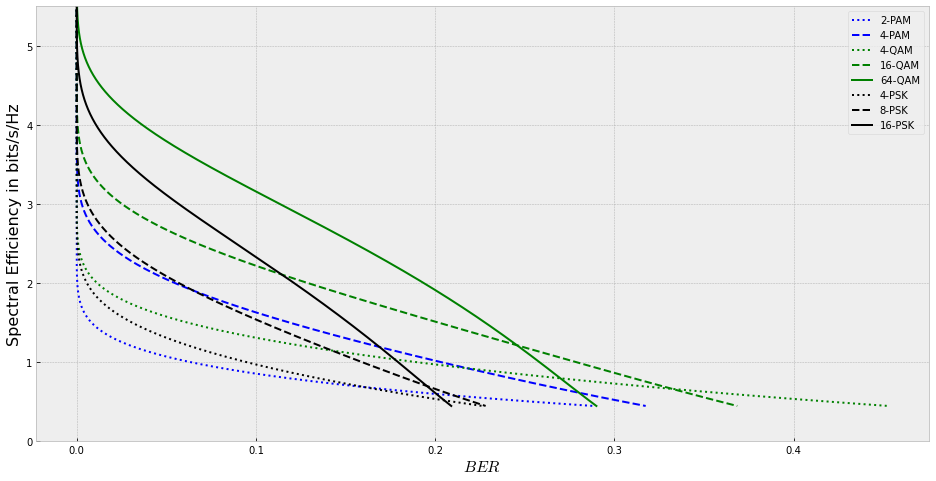

In [13]:
# Gray-code in use with labeling='reflected' and 'reflected_2d'
mod_2pam = komm.PAModulation(2, base_amplitude, labeling='reflected') 
mod_4pam = komm.PAModulation(4, base_amplitude, labeling='reflected')
mod_4qam = komm.QAModulation(4, base_amplitude, phase_offset=0.0, labeling='reflected_2d')
mod_16qam = komm.QAModulation(16, base_amplitude, phase_offset=0.0, labeling='reflected_2d')
mod_64qam = komm.QAModulation(64, base_amplitude, phase_offset=0.0, labeling='reflected_2d')
mod_4psk = komm.PSKModulation(4, base_amplitude, phase_offset=np.pi/4, labeling='reflected')
mod_8psk = komm.PSKModulation(8, base_amplitude, phase_offset=np.pi/8, labeling='reflected')
mod_16psk = komm.PSKModulation(16, base_amplitude, phase_offset=np.pi/16, labeling='reflected') 


# BER for GRAY-code with PAM and QAM: BER =~ 1/k * SER
#ber_prob_2pam = 1 / mod_2pam.bits_per_symbol * ser_prob_2pam # Old
ber_prob_2pam = [(1 / mod_2pam.bits_per_symbol * i) for i in ser_prob_2pam]
#ber_prob_4pam = 1 / mod_4pam.bits_per_symbol * ser_prob_4pam # Old
ber_prob_4pam = [(1 / mod_4pam.bits_per_symbol * i) for i in ser_prob_4pam]
#ber_prob_4qam = 1 / mod_4qam.bits_per_symbol * ser_prob_4qam # Old
ber_prob_4qam = [(1 / mod_4qam.bits_per_symbol * i) for i in ser_prob_4qam]
#ber_prob_16qam = 1 / mod_16qam.bits_per_symbol * ser_prob_16qam # Old
ber_prob_16qam = [(1 / mod_16qam.bits_per_symbol * i) for i in ser_prob_16qam]
#ber_prob_64qam = 1 / mod_64qam.bits_per_symbol * ser_prob_64qam # Old
ber_prob_64qam = [(1 / mod_64qam.bits_per_symbol * i) for i in ser_prob_64qam]

# BER for GRAY-code with PSK: BER =~ SER / k
#ber_prob_4psk = ser_prob_4psk / mod_4psk.bits_per_symbol # Old
ber_prob_4psk = [(i / mod_4psk.bits_per_symbol) for i in ser_prob_4psk]
#ber_prob_8psk = ser_prob_8psk / mod_8psk.bits_per_symbol # Old
ber_prob_8psk = [(i / mod_8psk.bits_per_symbol) for i in ser_prob_8psk]
#ber_prob_16psk = ser_prob_16psk / mod_16psk.bits_per_symbol # Old
ber_prob_16psk = [(i / mod_16psk.bits_per_symbol) for i in ser_prob_16psk]

#ax2.plot([10 * np.min(np.log10(EbperN0)), 10 * np.max(np.log10(EbperN0))], [np.log2(order),np.log2(order)],':k')

awgn_snrplus1 = []
[awgn_snrplus1.append(1+i) for i in awgn_snr]
# Plots
plt.figure(1,figsize=(16,8))
#plt.plot(ber_prob_2pam, np.log(1+awgn.snr),':b',label='2-PAM'); # Old
plt.plot(ber_prob_2pam, np.log(awgn_snrplus1),':b',label='2-PAM');
#plt.plot(ber_prob_4pam, np.log(1+awgn.snr),'--b',label='4-PAM'); # Old
plt.plot(ber_prob_4pam, np.log(awgn_snrplus1),'--b',label='4-PAM');
#plt.plot(ber_prob_4qam, np.log(1+awgn.snr),':g',label='4-QAM'); # Old
plt.plot(ber_prob_4qam, np.log(awgn_snrplus1),':g',label='4-QAM');
#plt.plot(ber_prob_16qam, np.log(1+awgn.snr),'--g',label='16-QAM'); # Old
plt.plot(ber_prob_16qam, np.log(awgn_snrplus1),'--g',label='16-QAM');
#plt.plot(ber_prob_64qam, np.log(1+awgn.snr),'g',label='64-QAM'); # Old
plt.plot(ber_prob_64qam, np.log(awgn_snrplus1),'g',label='64-QAM');
#plt.plot(ber_prob_4psk, np.log(1+awgn.snr),':k',label='4-PSK'); # Old
plt.plot(ber_prob_4psk, np.log(awgn_snrplus1),':k',label='4-PSK');
#plt.plot(ber_prob_8psk, np.log(1+awgn.snr),'--k',label='8-PSK'); # Old
plt.plot(ber_prob_8psk, np.log(awgn_snrplus1),'--k',label='8-PSK');
#plt.plot(ber_prob_16psk, np.log(1+awgn.snr),'k',label='16-PSK'); # Old
plt.plot(ber_prob_16psk, np.log(awgn_snrplus1),'k',label='16-PSK');
plt.ylim([0,5.5])
plt.xlabel('$BER$',fontsize=16);
plt.ylabel('Spectral Efficiency in bits/s/Hz', color='k',fontsize=16);
plt.legend();

**(c)** What is the capacity of this channel by plotting the curve of the Channel Capacity as a function of SNR.



The channel capacity C discrete time AWGN channel. It is given by $C=\dfrac{1}{2}  log_2(1+SNR)$, in bits per dimension.

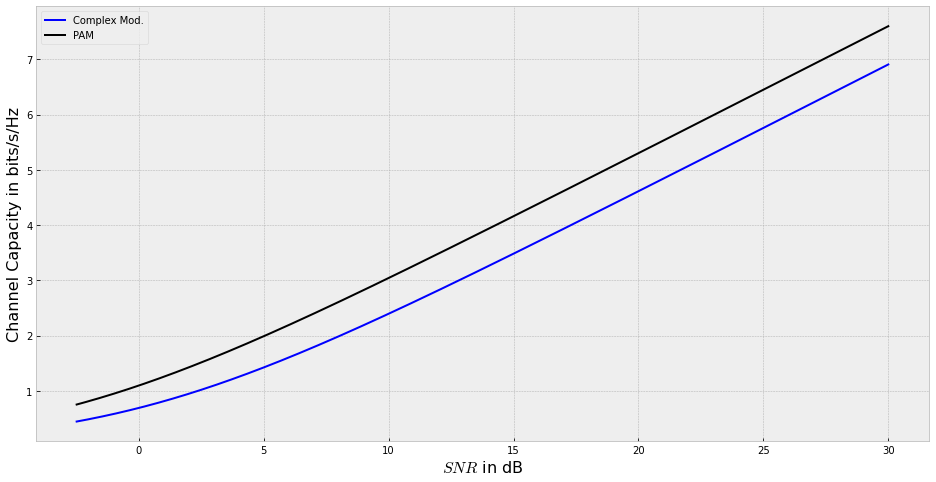

In [14]:
#EbperN0_2pam = awgn.snr / mod_2pam.bits_per_symbol
#EbperN0_4pam = awgn.snr / mod_4pam.bits_per_symbol
#EbperN0_4qam = awgn.snr / mod_4qam.bits_per_symbol
#EbperN0_16qam = awgn.snr / mod_16qam.bits_per_symbol
#EbperN0_64qam = awgn.snr / mod_64qam.bits_per_symbol
#EbperN0_4psk = awgn.snr / mod_4psk.bits_per_symbol
#EbperN0_8psk = awgn.snr / mod_8psk.bits_per_symbol
#EbperN0_16psk = awgn.snr / mod_16psk.bits_per_symbol


awgn_snrplus1x2 = []
[awgn_snrplus1x2.append(1+2*i) for i in awgn_snr]

# Plots
plt.figure(1,figsize=(16,8))
plt.plot(10 * np.log10(awgn_snr), np.log(awgn_snrplus1),'-b',label='Complex Mod.');
plt.plot(10 * np.log10(awgn_snr), np.log(awgn_snrplus1x2),'-k',label='PAM');
plt.xlabel('$SNR$ in dB',fontsize=16);
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),':b',label='2-PAM');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),'--b',label='4-PAM');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),':g',label='4-QAM');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),'--g',label='16-QAM');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),'g',label='64-QAM');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),':k',label='4-PSK');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),'--k',label='8-PSK');
#plt.plot(np.log(1+awgn.snr), np.log(1+awgn.snr),'k',label='16-PSK');
#plt.ylim([0,5.5])
#plt.xlabel('$SNR$',fontsize=16);
plt.ylabel('Channel Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend();



**(d)** With your own words, how you could improve the performance in relation to symbol-error rate and bit-error rate? (error rate and error probability mean the same thing here).

With modulated signals, the carrier signal is modulated to have some specific phase and amplitude for each symbol, as per the modulation scheme. When individual symbols phase and amplitude value is mapped on to the modulation constellation at the receiver, the corresponding bit-string can be determined. On a transmitted signal, the noise affects the individual symbols and which phase and amplitude they are received with at the receiver, and the transmitted symbol may get translated to some other symbol, and so a symbol error occurs.

The channels proneness to errors can be decreased in general by trying to increase it's SNR. Thereby, either decreasing noise power or by increasing signal power. When SNR cannot be influenced, the use of channel coding can be utilized to minimize the effects of symbol errors. With channel coding, a degree of strategical redundancy is introduced before transmission over the channel. At basic level, the coding can be simple repetitions of the symbols, though with poor performance. Better performing channel codes have been developed through intensive research, such as "turbo-codes" and LDPC codes.

**(e)** Is it possible to know how good is your solution?

The performance of a given coded modulation strategy can be compared to fundamental Shannon limits by comparing the SNR at which the channel attains a certain performance (i.e. a BER of 10e−5) with the minimum SNR required for reliable communication at that spectral efficiency.

# Diplomilaskut

**2. Evaluate the performance of the QPSK ($M=4$) in relation to Shannon capacity considering the symbol error probability: $$P \approx 2 Q \left(\sqrt{\dfrac{2 E_b \log_2 M}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right).$$**

**Consider the case of $M=4$ and plot the figure $P$ versus $E_b/N_0$ in db. Additionally, plot the Shannon capacity vs. $E_b/N_0$.**

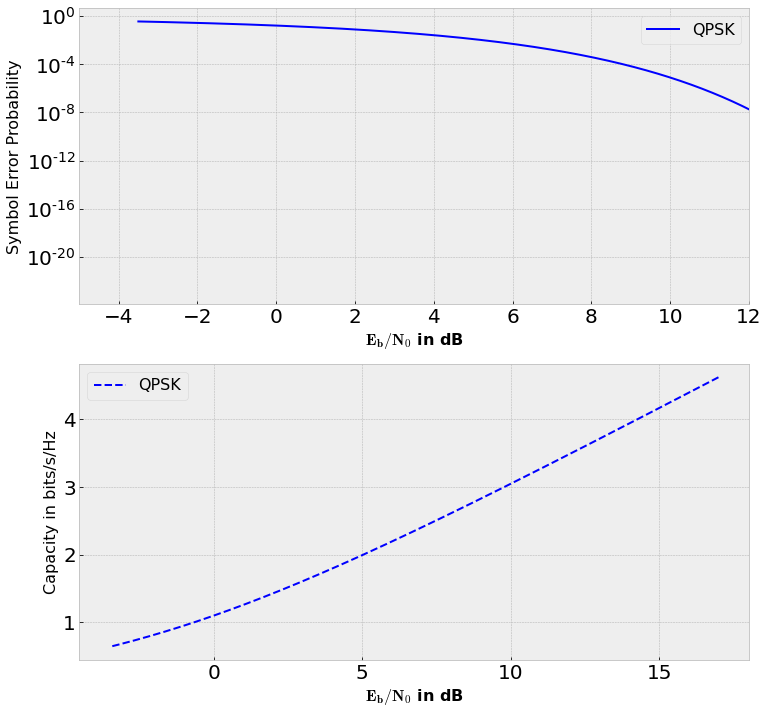

In [15]:
# An alternate way to approximate the Q-function.
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))

#QPSK
base_amplitude = 1
noise_power_db_qpsk = np.arange(-20, 0.5, 0.01)
noise_power_qpsk = 10**(noise_power_db_qpsk / 10)
awgn = komm.AWGNChannel()
order = 4
modulation = komm.PSKModulation(order, base_amplitude, phase_offset=np.pi/order)
awgn.signal_power_qpsk  = modulation.energy_per_symbol
awgn.snr_qpsk  = awgn.signal_power_qpsk  / noise_power_qpsk
EbperN0_qpsk  = awgn.snr_qpsk / modulation.bits_per_symbol
error_probability_qpsk  = 2*Q(np.sqrt( 2 * np.log2(order) * EbperN0_qpsk) * np.sin(np.pi/order))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

plt.figure(1,figsize=(12,12))
plt.subplot(211)
plt.semilogy(10 * np.log10(EbperN0_qpsk), error_probability_qpsk,'b',label='QPSK');
plt.xlabel('$\mathbf{E_b/N_0}$ in dB', fontsize=16, weight='bold')
plt.ylabel('Symbol Error Probability', color='k',fontsize=16)
plt.xlim([-5,12])
plt.legend(fontsize=16)

plt.subplot(212)
plt.plot(10 * np.log10(EbperN0_qpsk), np.log(1+awgn.snr_qpsk),'--b',label='QPSK');
plt.xlabel('$\mathbf{E_b/N_0}$ in dB', fontsize=16, weight='bold');
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16);
plt.legend(fontsize=16);


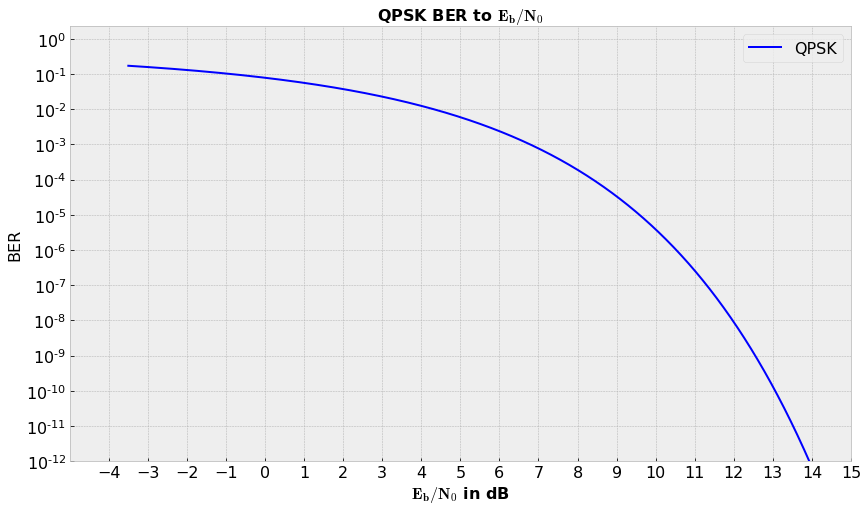

Required Eb/N0 for BER of 10^-6: 10.5 dB


In [16]:
# An alternate way to approximate the Q-function.
def Q(x):
    return 1/2*scipy.special.erfc(np.sqrt(x))

#QPSK
base_amplitude = 1
noise_power_db_qpsk = np.arange(-20, 0.5, 0.01)
noise_power_qpsk = 10**(noise_power_db_qpsk / 10)
awgn = komm.AWGNChannel()
order = 4
modulation = komm.PSKModulation(order, base_amplitude, phase_offset=np.pi/order)
awgn.signal_power_qpsk  = modulation.energy_per_symbol
awgn.snr_qpsk  = awgn.signal_power_qpsk  / noise_power_qpsk
EbperN0_qpsk  = awgn.snr_qpsk / modulation.bits_per_symbol
ber_qpsk  = Q(EbperN0_qpsk)

log_yticks = []
for i in range(15):
    log_yticks.append(10**(-1*i))

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.plot(10 * np.log10(EbperN0_qpsk), ber_qpsk,'b',label='QPSK')
ax.set_xlabel('$\mathbf{E_b/N_0}$ in dB', fontsize=16, weight='bold')  
ax.set_ylabel('BER', color='k',fontsize=16)  
ax.set_yscale("log") #the log transformation
ax.set_yticks(log_yticks)
ax.set_xticks(np.arange(-4,17,1))
ax.set_title("QPSK BER to $\mathbf{E_b/N_0}$", fontsize=16, weight='bold');
ax.set_xlim([-5,15])
ax.set_ylim([0.000000000001,0])
ax.legend(fontsize=16)
plt.show()

#ber_m6_ind = np.where(ber_qpsk == 0.172291561)
#print(ber_m6_ind)

#print(len(ber_qpsk))
#print(len(EbperN0_qpsk))
temp = []
for i in ber_qpsk:
    if i > 0.00000098:
        if i <= 0.00000101:
            temp.append(i)
#print(temp)
ber_m6 = 10 * np.log10(EbperN0_qpsk[np.where(ber_qpsk == temp)])
print("Required Eb/N0 for BER of 10^-6: {:.1f} dB".format(ber_m6[0]))
            
#print(ber_qpsk)
#print(10 * np.log10(EbperN0_qpsk))

#ber_minus6 = ber_qpsk
#print('Eb/N0 for BER of 10^-6 is: {}'.format(ber_minus6))


[1.30644489e-01 1.30455696e-01 1.30267241e-01 ... 6.83039583e-13
 6.82343795e-13 6.81648716e-13]


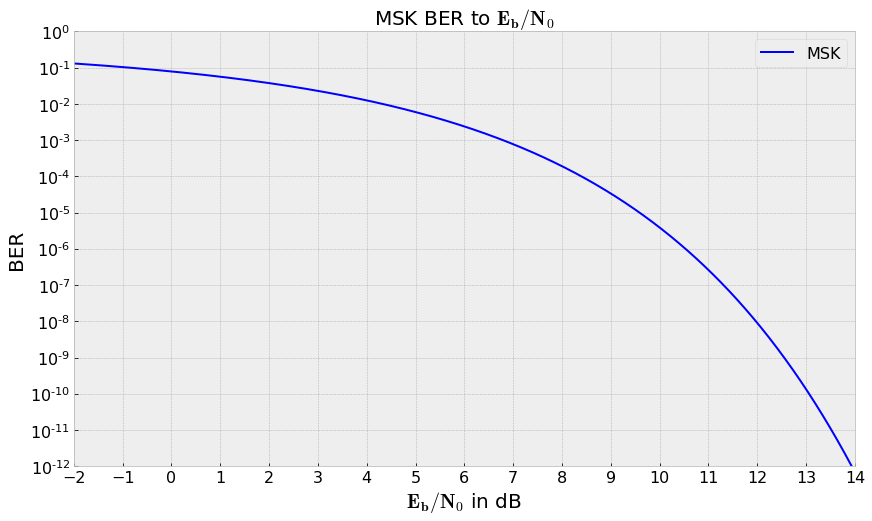

1.0005872838337071e-06
9.995462104378614e-07
Required Eb/N0 for BER of 10^-6: 10.5 dB


In [17]:
# BER to Eb/N0 for MSK:

# https://arxiv.org/ftp/arxiv/papers/1505/1505.05755.pdf
# TS-UNB protocol shall use MSK Modulation or GMSK Modulation with BT = 1.0 in the uplink. TS 103 357
    
    
# An alternate way to approximate the Q-function.
def Q(x):
    return 1/2*scipy.special.erfc(np.sqrt(x))

#QPSK eb/n0:
#base_amplitude = 1
#noise_power_db_gmsk = np.arange(-20, 0.5, 0.01)
#noise_power_qpsk = 10**(noise_power_db_gmsk / 10)
#awgn = komm.AWGNChannel()
#order = 4
#modulation = komm.MSKModulation(order, base_amplitude, phase_offset=np.pi/order)
#awgn.signal_power_qpsk  = modulation.energy_per_symbol
#awgn.snr_qpsk  = awgn.signal_power_qpsk  / noise_power_qpsk
#EbperN0_qpsk  = awgn.snr_qpsk / modulation.bits_per_symbol

EbN0_abs = np.arange(10**(-2.0/10),10**(14.0/10),0.001)

# BER MSK:
ber_msk = Q(EbN0_abs)
print(ber_msk)

log_yticks = []
for i in range(15):
    log_yticks.append(10**(-1*i))

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.plot((10*np.log10(EbN0_abs)), ber_msk,'b',label='MSK')
ax.set_xlabel('$\mathbf{E_b/N_0}$ in dB', fontsize=20)  
ax.set_ylabel('BER', color='k',fontsize=20)  
ax.set_yscale("log") #the log transformation
ax.set_yticks(log_yticks)
ax.set_xticks(np.arange(-2,15,1))
ax.set_title("MSK BER to $\mathbf{E_b/N_0}$", fontsize=20);
ax.set_xlim([-2,14])
ax.set_ylim([0.000000000001,0])
ax.legend(fontsize=16)
plt.show()

#print(len(ber_msk))
#rint(len(EbN0_abs))
temp = []
for i in ber_msk:
    if i > 0.000000999:
        if i <= 0.000001001:
            print(i)
            temp.append(i)
#print(temp)
ber_m6 = 10 * np.log10(EbN0_abs[np.where(ber_msk == temp[1])])
print("Required Eb/N0 for BER of 10^-6: {:.1f} dB".format(ber_m6[0]))
            
#print(ber_qpsk)
#print(10 * np.log10(EbperN0_qpsk))

#ber_minus6 = ber_qpsk
#print('Eb/N0 for BER of 10^-6 is: {}'.format(ber_minus6))


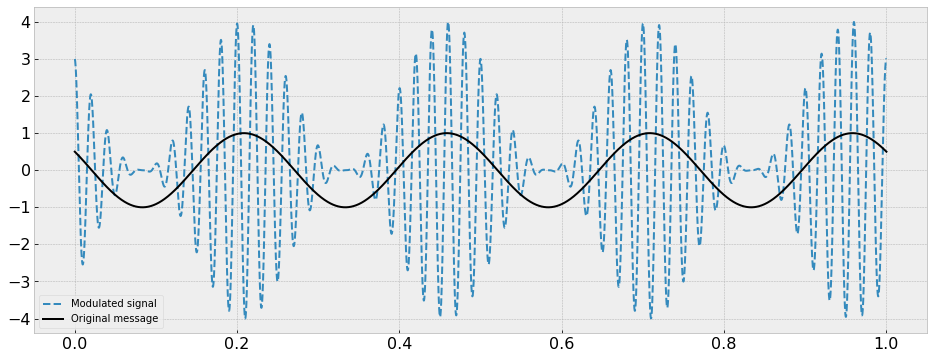

In [18]:
import sympy as sp
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
plt.rcParams['figure.figsize'] = 16, 6
import warnings
warnings.filterwarnings('ignore')

s1,s2,s3,s4,m,t,A,Am,Ac,fm,fc,w = sp.symbols('s_1,s_2,s_3,s_4,m,t,A,A_m,A_c,f_m,f_c,omega')
m = sp.Function('m')(t)
#print('Numerical example. Message:')
s3 = Am*sp.cos(8*sp.pi*t+w)

#uAM(t) = Am(t) cos(2πfct) + Ac cos(2πfct)
s2 = A*m*sp.cos(2*sp.pi*fc*t)+Ac*sp.cos(2*sp.pi*fc*t)
#print('Modulation equation:')

#A = A_c = 2 and f_c = 50
#print('Message in blue, Transmitted signal in red:')
Signal = s3.subs(w,(sp.pi/3)).subs(Am,1)
Modulated = s2.subs(m,s3).subs(A,2).subs(Ac,2).subs(fc,50).subs(w,(sp.pi/3)).subs(Am,1)
p = sp.plot(Modulated, Signal, (t, -0.4, 0.4), show=False)
p[0].line_color = 'r'
p[1].line_color = 'b'
#p.show()

#converting sympy formulas to numpy
#message =  sp.lambdify(t,s3.subs(w,(sp.pi/3)),"numpy")
#modulation_only = sp.lambdify(t,s2.subs(m,s3).subs(A,2).subs(Ac,2).subs(fc,50).subs(w,(sp.pi/3)),"numpy")
SignalNP =  sp.lambdify(t,Signal,"numpy")
ModulatedNP = sp.lambdify(t,Modulated,"numpy")

fp = 10000
tp = np.linspace(0,1,fp)
plt.rcParams['figure.figsize'] = 16, 6
plt.plot(tp, ModulatedNP(tp),linestyle='--',label='Modulated signal')
plt.plot(tp,  SignalNP(tp),'k-',label='Original message')
plt.legend(loc='lower left')
plt.show()
#plt.plot(tp,  2*SignalNP(tp),'k-',label='2*message')
#plt.plot(tp, modulation_only(tp)*message(tp),':')
#plt.legend(loc='lower left')
#plt.show()

In [19]:
# Calculating uplink NB-IoT Eb/N0 for BPSK and QPSK modulation

S = [-123.4, -119.4, -115.4, -107.4, -103.4, -99.4, -95.4, -91.4, -87.4, -83.4] # Carrier signal average power at receiver
T = 290 # Kelvin
Boltzmann_dB = (10 * np.log10(Boltzmann))
N0 = (10 * np.log10(T)) + Boltzmann_dB # Thermal noise per Hz
NF = 3 # Noise Figure in dB
B = 15000 # Hz for single NB-IoT subcarrier
B_dB = 10 * np.log10(B)
N = NF + N0 + 10 * np.log10(B) # Total average noise power over channel bandwidth B
Ts = 0.0005 / 7 # slot duration in seconds / symbols per slot, in Nb-IoT = symbol duration
k = 2 # bits per symbol
Rb = 10 * np.log10((1 / Ts) * np.log2(2**k)) # bitrate in dB

print(Boltzmann_dB)
print(N0)

#SNR = []
#for i in signal_rx:
#    SNR.append(i - 30 - N) # substract 30 dB to convert dBm to dB
#print(SNR)



#EbperN0_NBIoT = []
#for i in signal_rx:
#    EbperN0_NBIoT.append(i - 30 + NF - N0 + B_dB - Rb) # substract 30 dB to convert dBm to dB

#print(EbperN0_NBIoT)

#plt.rcParams['figure.figsize'] = 16, 6
#plt.plot(SNR, S,linestyle='--',label='SNR, uncoded signal')
#plt.legend(loc='lower right')
#plt.show()

-228.59916717321767
-203.9751871942281


In [20]:
P_Tx = 23 # dB
G_Tx = 0 # dBi
G_Rx = 17 # dBi
M_I = 4 # dB
L_C = 3 # dB

P_NoiseFloor = 10*np.log10(k*T*1000) + NF + 10*np.log10(B)

#print("PL_open: ", PL_open)
print("P_Tx: ", P_Tx)
print("G_Tx: ", G_Tx)
print("G_Rx: ", G_Rx)
#print("P_NT: ", P_NT)
#print("log_B: ", log_B)
print("NF: ", NF)
#print("P_Neff: ", P_Neff)
#print("P_NT + log_B + NF: ", P_NT + log_B + NF)
print("NoiseFloor: ", P_NoiseFloor)
print("M_I: ", M_I)
print("L_C: ", L_C)


#SNR_reqd = PL_open - P_Tx - G_Tx - G_Rx + P_NT - log_B - NF + M_I + L_C
#SNR_reqd =  P_Tx + G_Tx + G_Rx - P_Neff - M_I - PL_open
#print("\n")
#print("SNR required for 1000m in rural/open Hata/COST 231 model: ", SNR_reqd)

#P_RXmin = P_Neff + SNR_min

P_Tx:  23
G_Tx:  0
G_Rx:  17
NF:  3
NoiseFloor:  102.39519252618618
M_I:  4
L_C:  3


In [21]:
T = 290 # Kelvin
B = 60223/24
k = Boltzmann
NF = 6

P_NT = 10 * np.log10(k*T/0.001) # 1 mW
P_NT2 = 10 * np.log10(k*T*1000) # 1000 mW, 2-ways apparently
print("Thermal Noise:")
print(P_NT)
print(P_NT2)
print("\n")

P_N0 = 10 * np.log10(k*T*B*1000) # 1000 mW, 2-ways apparently
print("Noise Power N0:")
print(P_N0)
print("\n")

Thermal Noise:
-173.97518719422808
-173.97518719422808


Noise Power N0:
-139.9796757510225




In [22]:
# NB-IoT. Calculating APL given SNR_reqd for each TBS-index 
B_SC = 15000 # Subcarrier bandwidth in Hz
N_SC = 12 # No. subcarriers
B = B_SC * N_SC # Total channel bandwidth
print("B: ", B)
B_dB = 10 * np.log10(B_SC * N_SC) # Total channel bandwidth in dBs
print("B_dB: ", B_dB)
H_TX = 2 # UE antenna height in meters
H_RX = 20 # eNodeB antenna height in meters
P_TX = 23 # dB
G_TX = 0 # dBi
EIRP = P_TX + G_TX
print("EIRP: ", EIRP)
G_RX = 17 # dBi
k = Boltzmann # Boltzmann constant, k = 1.38064852 × 10^-23 m2 kg s-2 K-1
T = 290 # degrees Kelvin
N0 = 10 * np.log10(k*T*1000) # Thermal Noise normalized per Hz. 1000 mW --> result in dBm
N = N0 + B_dB 
print("N0: ", N0)
NF = 3 # Noise Figure, dB
print("NF: ", NF)
SNR_reqd = [[-3.3, -6.3, -7.2, -7.5, -5.9, -6.5, -7.0, -7.6],
            [-2.5, -3.2, -4.1, -3.8, -4.3, -4.0, -6.0, -6.4],
            [-0.9, -2.2, -2.1, -2.9, -4.0, -4.0, -5.2, -5.4],
            [0.0, -0.5, -1.2, -2.2, -3.1, -3.2, -4.2, -4.0],
            [0.9, -0.1, -0.5, -1.2, -1.7, -1.8, -3.2, -3.7],
            [1.6, 0.5, -0.1, -0.4, -0.9, -1.4, -2.0, -2.6],
            [2.7, 1.6, 0.6, 0.6, 0.0, -0.6, -1.3, -2.0],
            [3.7, 2.7, 1.7, 1.8, 0.6, 0.4, -0.1, -0.8],
            [4.2, 3.6, 2.8, 2.4, 2.1, 1.2, 0.7, -0.1],
            [5.1, 4.5, 3.7, 3.3, 2.8, 2.2, 1.6, 0.7],
            [5.5, 5.2, 4.6, 4.0, 4.0, 2.9, 2.1, 1.7],
            [6.8, 6.5, 6.0, 5.5, 4.9, 3.9, 3.4, 2.8],
            [8.4, 7.8, 7.2, 8.0, 5.7, 5.3, 4.4, 3.8],
            [9.5, 9.3, 8.5, 8.8, 7.0, 6.9, 5.8, 5.2]]
print("\nSNR_reqd table, dB:\n", tabulate(SNR_reqd, floatfmt=".1f"))

P_RXmin = [] # Receiver sensitivity, dB
for i in range(len(SNR_reqd)):
    #print("\nMCS index, i: {}".format(i))
    P_RXmin.append([])
    for j in range(len(SNR_reqd[i])):
        P_RXmin[i].append(round(N0 + B_dB + NF + SNR_reqd[i][j], 1))
        #print("j: {}, SNR_reqd value: {}, P_RXmin: {}".format(j, SNR_reqd[i][j], P_RXmin[i][j]))
print("\nP_RXmin table, dB:\n", tabulate(P_RXmin, floatfmt=".1f"))
G_REP = 3 # 

M_SF = 7 # Shadowing margin, dB
M_I = 4 # Interference margin, dB
M_Total = M_SF + M_I
print("M_Total: ", M_Total)
L_CTX = 0 # TX cable loss, dB
L_CRX = 3 # RX cable loss, dB
L_Total = L_CTX + L_CRX
print("L_Total: ", L_Total)

APL = []
for i in range(len(P_RXmin)):
    #print("\nMCS index, i: {}".format(i))
    APL.append([])
    for j in range(len(P_RXmin[i])):
        
        result = EIRP + G_RX - P_RXmin[i][j] - M_Total - L_Total
        
        APL[i].append(round(result, 1))
        #print("j: {}, P_RXmin value: {}, APL: {}".format(j, P_RXmin[i][j], APL[i][j]))

print("\nAPL table, dB:\n", tabulate(APL, floatfmt=".1f"))



B:  180000
B_dB:  52.552725051033065
EIRP:  23
N0:  -173.97518719422808
NF:  3

SNR_reqd table, dB:
 ----  ----  ----  ----  ----  ----  ----  ----
-3.3  -6.3  -7.2  -7.5  -5.9  -6.5  -7.0  -7.6
-2.5  -3.2  -4.1  -3.8  -4.3  -4.0  -6.0  -6.4
-0.9  -2.2  -2.1  -2.9  -4.0  -4.0  -5.2  -5.4
 0.0  -0.5  -1.2  -2.2  -3.1  -3.2  -4.2  -4.0
 0.9  -0.1  -0.5  -1.2  -1.7  -1.8  -3.2  -3.7
 1.6   0.5  -0.1  -0.4  -0.9  -1.4  -2.0  -2.6
 2.7   1.6   0.6   0.6   0.0  -0.6  -1.3  -2.0
 3.7   2.7   1.7   1.8   0.6   0.4  -0.1  -0.8
 4.2   3.6   2.8   2.4   2.1   1.2   0.7  -0.1
 5.1   4.5   3.7   3.3   2.8   2.2   1.6   0.7
 5.5   5.2   4.6   4.0   4.0   2.9   2.1   1.7
 6.8   6.5   6.0   5.5   4.9   3.9   3.4   2.8
 8.4   7.8   7.2   8.0   5.7   5.3   4.4   3.8
 9.5   9.3   8.5   8.8   7.0   6.9   5.8   5.2
----  ----  ----  ----  ----  ----  ----  ----

P_RXmin table, dB:
 ------  ------  ------  ------  ------  ------  ------  ------
-121.7  -124.7  -125.6  -125.9  -124.3  -124.9  -125.4  -126.0


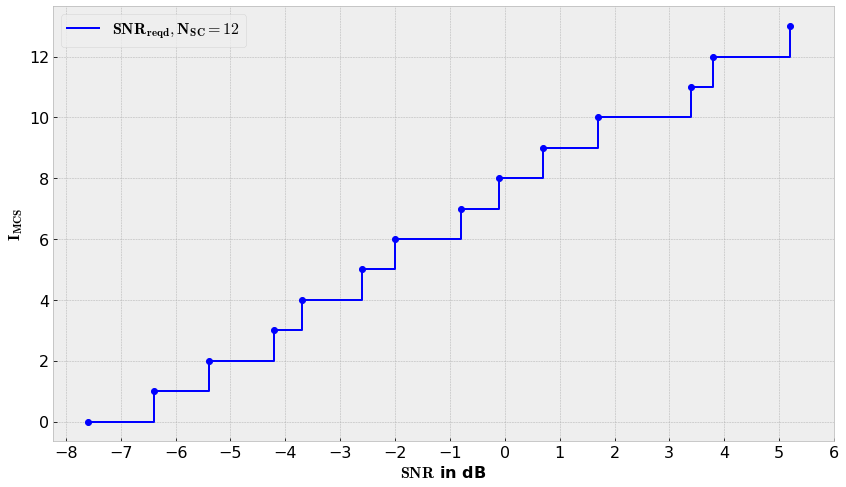

In [23]:
# NB-IoT uplink NPUSCH I_MCS min. SNR_reqd
NB_SNR_reqd = [-7.6, -6.4, -5.4, -4.2, -3.7, -2.6, -2.0, -0.8, -0.1, 0.7, 1.7, 3.4, 3.8, 5.2]
I_MCS = list(range(14))

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.step(NB_SNR_reqd, I_MCS,'b',label='$\mathbf{SNR_{reqd}, N_{SC}=12}$', where='post')
ax.plot(NB_SNR_reqd, I_MCS,'ob', alpha=1.0)
ax.set_xlabel('$\mathbf{SNR}$ in dB', fontsize=16, weight='bold')  
ax.set_ylabel('$\mathbf{I_{MCS}}$', color='k',fontsize=16)  
ax.set_xticks(np.arange(-8,7,1))
#ax.set_title("QPSK BER to $\mathbf{E_b/N_0}$", fontsize=16, weight='bold');
#ax.set_xlim([-8,7])
#ax.set_ylim([0.000000000001,0])
ax.legend(fontsize=16)
plt.show()

#ber_m6_ind = np.where(ber_qpsk == 0.172291561)
#print(ber_m6_ind)

In [24]:
# LoRaWAN. Calculating APL given SNR_reqd for each SF. 
B_SC = 125000 # Subcarrier bandwidth in Hz
N_SC = 1 # No. subcarriers
B = B_SC * N_SC # Total channel bandwidth
print("B: ", B)
B_dB = 10 * np.log10(B_SC * N_SC) # Total channel bandwidth in dBs
print("B_dB: ", B_dB)
H_TX = 2 # UE antenna height in meters
H_RX = 40 # eNodeB antenna height in meters
P_TX = 14 # dB
G_TX = 0 # dBi

EIRP = P_TX + G_TX
print("EIRP: ", EIRP)
G_RX = 17 # dBi
k = Boltzmann # Boltzmann constant, k = 1.38064852 × 10^-23 m2 kg s-2 K-1
T = 290 # degrees Kelvin
N0 = 10 * np.log10(k*T*1000) # Thermal Noise normalized per Hz. 1000 mW --> result in dBm
print("N0: ", N0)
N = N0 + B_dB 
print("N: ", N)
NF = 6 # Noise Figure, dB
print("NF: ", NF)

SNR_reqd= [-5, -7.5, -10, -12.5, -15, -17.5, -20]

P_RXmin = [] # Receiver sensitivity, dB
for i in range(len(SNR_reqd)):
    #print("i: ", i)
    #print("SNR_reqd: ", SNR_reqd[i])
    P_RXmin.append(round(N0 + B_dB + NF + SNR_reqd[i], 1))
    print("i: {}, SNR_reqd value: {}, P_RXmin: {}".format(i, SNR_reqd[i], P_RXmin[i]))

M_SF = 7 # Shadowing margin, dB
M_I = 4 # Interference margin, dB
M_Total = M_SF + M_I
print("M_Total: ", M_Total)
L_CTX = 0 # TX cable loss, dB
L_CRX = 3 # RX cable loss, dB
L_Total = L_CTX + L_CRX
print("L_Total: ", L_Total)

APL = []
for i in range(len(P_RXmin)):
    APL.append(round(EIRP + G_RX - P_RXmin[i] - M_Total - L_Total, 1))
    print("i: {}, P_RXmin value: {}, APL: {}".format(i, P_RXmin[i], APL[i]))
print(APL)

B:  125000
B_dB:  50.96910013008056
EIRP:  14
N0:  -173.97518719422808
N:  -123.00608706414752
NF:  6
i: 0, SNR_reqd value: -5, P_RXmin: -122.0
i: 1, SNR_reqd value: -7.5, P_RXmin: -124.5
i: 2, SNR_reqd value: -10, P_RXmin: -127.0
i: 3, SNR_reqd value: -12.5, P_RXmin: -129.5
i: 4, SNR_reqd value: -15, P_RXmin: -132.0
i: 5, SNR_reqd value: -17.5, P_RXmin: -134.5
i: 6, SNR_reqd value: -20, P_RXmin: -137.0
M_Total:  11
L_Total:  3
i: 0, P_RXmin value: -122.0, APL: 139.0
i: 1, P_RXmin value: -124.5, APL: 141.5
i: 2, P_RXmin value: -127.0, APL: 144.0
i: 3, P_RXmin value: -129.5, APL: 146.5
i: 4, P_RXmin value: -132.0, APL: 149.0
i: 5, P_RXmin value: -134.5, APL: 151.5
i: 6, P_RXmin value: -137.0, APL: 154.0
[139.0, 141.5, 144.0, 146.5, 149.0, 151.5, 154.0]


In [25]:
# TS-UNB. Calculating APL given SNR_reqd for each TBS-index 
B = 60233 # Total channel bandwidth in Hz
B100kHz = 100000 # Total channel bandwidth in Hz, including guard bands between SCs
N_SC = 24 # No. subcarriers
B_SC = B/N_SC # Subcarrier bandwidth
print("B_SC: ", B_SC)
B_SC_dB = 10 * np.log10(B_SC) # Subcarrier bandwidth in dBs
B_dB = 10 * np.log10(B100kHz) # Total channel bandwidth in dBs
print("B_dB: ", B_dB)
H_TX = 2 # UE antenna height in meters
H_RX = 40 # BS antenna height in meters
P_TX = 14 # dB
G_TX = 0 # dBi
EIRP = P_TX + G_TX
print("EIRP: ", EIRP)
G_RX = 6 # dBi
k = Boltzmann # Boltzmann constant, k = 1.38064852 × 10^-23 m2 kg s-2 K-1
T = 290 # degrees Kelvin
N0 = 10 * np.log10(k*T*1000) # Thermal Noise normalized per Hz. 1000 mW --> result in dBm
N = N0 + B_dB
print("N0: ", N0)
NF = 6 # Noise Figure, dB
print("NF: ", NF)

Rb = 2380.371
EbN0 = 10.5
SNR_reqd_ana = EbN0 - (10*np.log10(B100kHz/Rb))
#SNR_reqd_ana = 0.64608
S_mes = -126 # dBm
N = 10**(N0/10) * B100kHz
N_dB = 10*np.log10(N)
print("N_dB: ", N_dB)
SNR_reqd_mes = S_mes - N_dB
print("SNR_reqd_mes: ", SNR_reqd_mes)

P_RXmin_ana = N0 + B_dB + NF + SNR_reqd_ana
P_RXmin_mes = N0 + B_dB + NF + SNR_reqd_mes
print("SNR_reqd Analytical value: {}, P_RXmin: {}".format(SNR_reqd_ana, P_RXmin_ana))
print("SNR_reqd Measured value: {}, P_RXmin: {}".format(SNR_reqd_mes, P_RXmin_mes))

M_SF = 7 # Shadowing margin, dB
M_I = 4 # Interference margin, dB
M_Total = M_SF + M_I
print("M_Total: ", M_Total)
L_CTX = 0 # TX cable loss, dB
L_CRX = 3 # RX cable loss, dB
L_Total = L_CTX + L_CRX
print("L_Total: ", L_Total)

APL_ana = round(EIRP + G_RX - P_RXmin_ana - M_Total - L_Total, 1)
APL_mes = round(EIRP + G_RX - P_RXmin_mes - M_Total - L_Total, 1)
        
print("APL Analytical: {}".format(APL_ana))
print("APL Measured: {}".format(APL_mes))



B_SC:  2509.7083333333335
B_dB:  50.0
EIRP:  14
N0:  -173.97518719422808
NF:  6
N_dB:  -123.97518719422808
SNR_reqd_mes:  -2.0248128057719157
SNR_reqd Analytical value: -5.733553493737588, P_RXmin: -123.70874068796567
SNR_reqd Measured value: -2.0248128057719157, P_RXmin: -120.0
M_Total:  11
L_Total:  3
APL Analytical: 129.7
APL Measured: 126.0


## Okumura-Hata Model Path Loss

In [26]:
# Okumura-Hata model, Extended 1500-2000 MHz
# For NB-IoT Uplink:

f_MHz = 880.09 # MHz
d_km = 1 # km
h_UE = 2 # meter
h_BS = 40 # meter

# Correction factors for UE antenna height
if 150 < f_MHz and f_MHz < 200:
    a_hUE_city = 8.3 * (math.log10(1.54 * h_UE))**2 - 1.1
else:
    a_hUE_city = 3.2 * (math.log10(11.75 * h_UE))**2 - 5.0 # Must be within 200 MHz < f_MHz < 1500 MHz.

a_hUE_town = 0.8 + (1.1 * math.log10(f_MHz) - 0.7) * h_UE - (1.56 * math.log10(f_MHz))

a_hUE_suburban = a_hUE_town + 2 * (math.log10(f_MHz/28))**2 + 5.4
a_hUE_open = a_hUE_town + 4.78 * (math.log10(f_MHz))**2 - (18.3 * math.log10(f_MHz)) + 40.9
                                                             
C_m_metro = 3 # dB
C_m_others = 0 # dB

PL_Hata_city = 46.3 + 33.9 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) - a_hUE_city + (44.9 - 6.55 * math.log10(h_BS)) * math.log10(d_km) + C_m_metro
PL_Hata_town = 46.3 + 33.9 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) - a_hUE_town + (44.9 - 6.55 * math.log10(h_BS)) * math.log10(d_km) + C_m_others
PL_Hata_suburban = 46.3 + 33.9 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) - a_hUE_suburban + (44.9 - 6.55 * math.log10(h_BS)) * math.log10(d_km) + C_m_others
PL_Hata_open = 46.3 + 33.9 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) - a_hUE_open + (44.9 - 6.55 * math.log10(h_BS)) * math.log10(d_km) + C_m_others

print("Okumura-Hata path-loss @ {}km for:".format(d_km))
print("urban city: {:.2f} (dB)".format(PL_Hata_city))
print("urban town: {:.2f} (dB)".format(PL_Hata_town))
print("suburban area: {:.2f} (dB)".format(PL_Hata_suburban))
print("rural/open areas: {:.2f} (dB)".format(PL_Hata_open))
print("\n")

#print("{:.4f}".format(piste), end=" ")



Okumura-Hata path-loss @ 1km for:
urban city: 125.96 (dB)
urban town: 122.69 (dB)
suburban area: 112.81 (dB)
rural/open areas: 94.24 (dB)




## COST/Hata 213 Path Loss

Urban:  
$L_50(urban) = 69.55 + 26.16 log_10(f_MHz) − 13.82 log_10(h_tx) − a(h_rx) + \[44.9 − 6.55 log_10(h_tx)\] log_10(d_km)

For small- and medium sized city, a(h_rx) = (1.1 log_10(f_MHz) - 0.7) h_rx - (1.56 log_10(f_MHz) - 0.8)
For large city @ frequencies above 300 MHz, a(h_rx) = 3.2 (log_10(11.75 h_rx))^2 - 4.97


Suburban: L_50(suburban) = L_50(urban) - 2(log_10(f_MHz/28))^2 -5.4


Rural/open areas:  L_50(open) = L_50(urban) - 4.78 (log_10(f_MHz))^2 + 18.33 log_10(f_MHz) - 40.98

COST/Hata 312 path-loss @ 1km for:
urban city: 123.42 (dB)
urban town: 123.15 (dB)
suburban area: 113.27 (dB)
rural/open areas: 94.69 (dB)




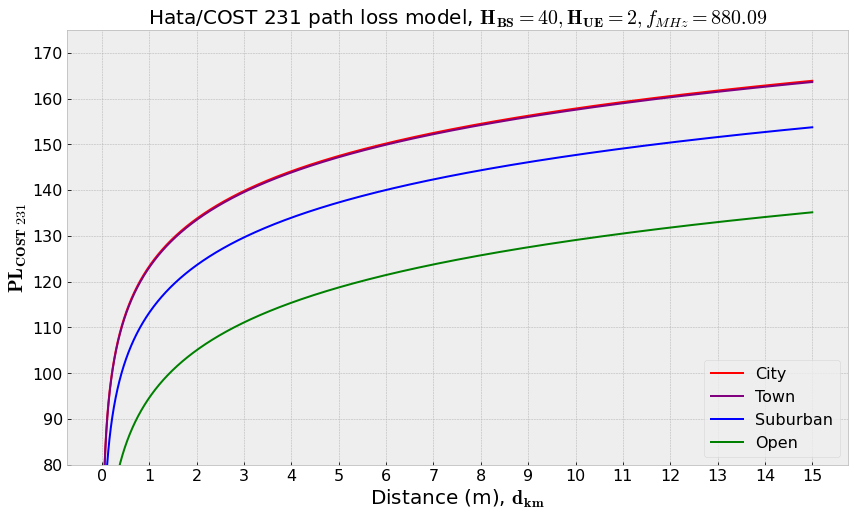

In [27]:
# COST 231 Extension to the Okumura-Hata model
# For NB-IoT Uplink:
f_MHz = 880.09 # MHz

d_km = 1 # km
npd_km = np.arange(0.001,15.001,0.001) # km
#print(npd_km)
h_UE = 2 # meter
h_BS = 40 # meter

# Correction factors for UE antenna height
if 150 < f_MHz and f_MHz < 200:
    a_hUE_city = 8.3 * (math.log10(1.54 * h_UE))**2 - 1.1
else:
    a_hUE_city = 3.2 * (math.log10(11.75 * h_UE))**2 - 5.0 # Must be within 200 MHz < f_MHz < 1500 MHz.

a_hUE_town = 0.8 + (1.1 * math.log10(f_MHz) - 0.7) * h_UE - (1.56 * math.log10(f_MHz))

#print("a_hUE_city: ", a_hUE_city)
#print("a_hUE_town: ", a_hUE_town)

a_hUE_suburban = a_hUE_town + 2 * (math.log10(f_MHz/28))**2 + 5.4
a_hUE_open = a_hUE_town + 4.78 * (math.log10(f_MHz))**2 - (18.3 * math.log10(f_MHz)) + 40.9

A = 69.55 + 26.16 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) 
B = (44.9 - 6.55 * math.log10(h_BS))

PL_COST231_city = []
PL_COST231_town = []
PL_COST231_suburban = []
PL_COST231_open = []

for i in npd_km:
    if i <= 20:
        beta = 1
    else:
        beta = 1 + (0.14 + 1.87 * 10**(-4) * f_MHz + 0.00107 * h_BS) * (math.log10(i/20))**0.8 # valid for distances betwee 20 and 100 km
    PL_COST231_city.append(A - a_hUE_city + B * (math.log10(i))**beta)
    PL_COST231_town.append(A - a_hUE_town + B * (math.log10(i))**beta)
    PL_COST231_suburban.append(A - a_hUE_suburban + B * (math.log10(i))**beta)
    PL_COST231_open.append(A - a_hUE_open + B * (math.log10(i))**beta)
    
#print("Beta is: {}".format(beta))

PL_COST231_city_1km = A - a_hUE_city + B * (math.log10(d_km))**beta
PL_COST231_town_1km = A - a_hUE_town + B * (math.log10(d_km))**beta
PL_COST231_suburban_1km = A - a_hUE_suburban + B * (math.log10(d_km))**beta
PL_COST231_open_1km = A - a_hUE_open + B * (math.log10(d_km))**beta

print("COST/Hata 312 path-loss @ {}km for:".format(d_km))
print("urban city: {:.2f} (dB)".format(PL_COST231_city_1km))
print("urban town: {:.2f} (dB)".format(PL_COST231_town_1km))
print("suburban area: {:.2f} (dB)".format(PL_COST231_suburban_1km))
print("rural/open areas: {:.2f} (dB)".format(PL_COST231_open_1km))
print("\n")

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.plot(npd_km, PL_COST231_city, color="red", label='City')
ax.plot(npd_km, PL_COST231_town, color="purple", label='Town')
ax.plot(npd_km, PL_COST231_suburban, color="blue", label='Suburban')
ax.plot(npd_km, PL_COST231_open, color="green", label='Open')
ax.set_xlabel('Distance (m), $\mathbf{d_{km}}$', fontsize=20) #, weight='bold') 
ax.set_xticks(np.arange(0,16,1))
ax.set_ylabel('$\mathbf{PL_{COST\ 231}}$', color='k',fontsize=20)  
ax.set_yticks(np.arange(80,175,10))
ax.set_title("Hata/COST 231 path loss model, $\mathbf{H_{BS}=40, H_{UE}=2}, f_{MHz}=880.09$", fontsize=20);
#ax.set_xlim([-5,15])
ax.set_ylim([80,175])
ax.legend(fontsize=16, loc='lower right')
plt.show()

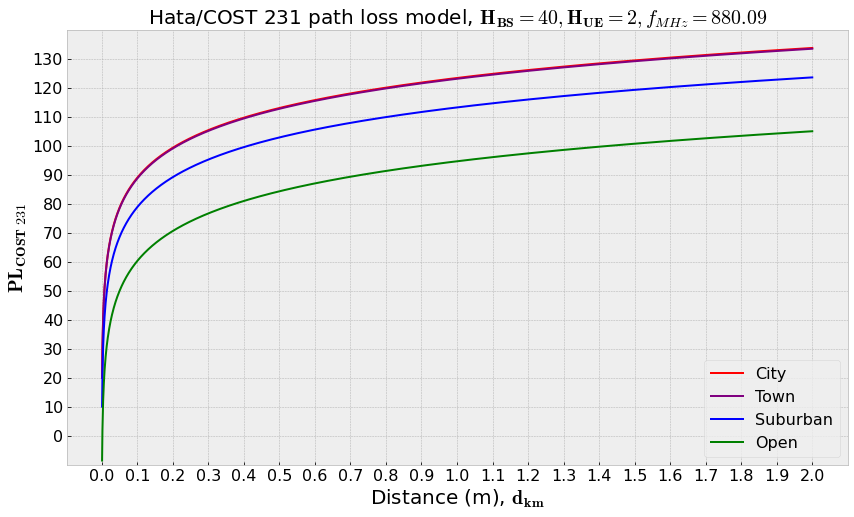

In [28]:
# COST 231 Extension to the Okumura-Hata model
# For NB-IoT Uplink:
f_MHz = 880.09 # MHz

d_km = 1 # km
npd_km = np.arange(0.001,2.001,0.001) # km
#print(npd_km)
h_UE = 2 # meter
h_BS = 40 # meter

# Correction factors for UE antenna height
if 150 < f_MHz and f_MHz < 200:
    a_hUE_city = 8.3 * (math.log10(1.54 * h_UE))**2 - 1.1
else:
    a_hUE_city = 3.2 * (math.log10(11.75 * h_UE))**2 - 5.0 # Must be within 200 MHz < f_MHz < 1500 MHz.

a_hUE_town = 0.8 + (1.1 * math.log10(f_MHz) - 0.7) * h_UE - (1.56 * math.log10(f_MHz))

#print("a_hUE_city: ", a_hUE_city)
#print("a_hUE_town: ", a_hUE_town)

a_hUE_suburban = a_hUE_town + 2 * (math.log10(f_MHz/28))**2 + 5.4
a_hUE_open = a_hUE_town + 4.78 * (math.log10(f_MHz))**2 - (18.3 * math.log10(f_MHz)) + 40.9

A = 69.55 + 26.16 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) 
B = (44.9 - 6.55 * math.log10(h_BS))

PL_COST231_city = []
PL_COST231_town = []
PL_COST231_suburban = []
PL_COST231_open = []

for i in npd_km:
    if i <= 20:
        beta = 1
    else:
        beta = 1 + (0.14 + 1.87 * 10**(-4) * f_MHz + 0.00107 * h_BS) * (math.log10(i/20))**0.8 # valid for distances betwee 20 and 100 km
    PL_COST231_city.append(A - a_hUE_city + B * (math.log10(i))**beta)
    PL_COST231_town.append(A - a_hUE_town + B * (math.log10(i))**beta)
    PL_COST231_suburban.append(A - a_hUE_suburban + B * (math.log10(i))**beta)
    PL_COST231_open.append(A - a_hUE_open + B * (math.log10(i))**beta)
    
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.plot(npd_km, PL_COST231_city, color="red", label='City')
ax.plot(npd_km, PL_COST231_town, color="purple", label='Town')
ax.plot(npd_km, PL_COST231_suburban, color="blue", label='Suburban')
ax.plot(npd_km, PL_COST231_open, color="green", label='Open')
ax.set_xlabel('Distance (m), $\mathbf{d_{km}}$', fontsize=20) #, weight='bold')
ax.set_xticks(np.arange(0,2.1,0.1))
ax.set_ylabel('$\mathbf{PL_{COST\ 231}}$', color='k',fontsize=20)
ax.set_yticks(np.arange(0,140,10))
ax.set_title("Hata/COST 231 path loss model, $\mathbf{H_{BS}=40, H_{UE}=2}, f_{MHz}=880.09$", fontsize=20);
#ax.set_xlim([-5,15])
ax.set_ylim([-10,140])
ax.legend(fontsize=16) #, loc='lower center')
plt.show()

COST/Hata 312 path-loss @ 1km for:
urban city: 123.42 (dB)
urban town: 123.15 (dB)
suburban area: 113.27 (dB)
rural/open areas: 94.69 (dB)




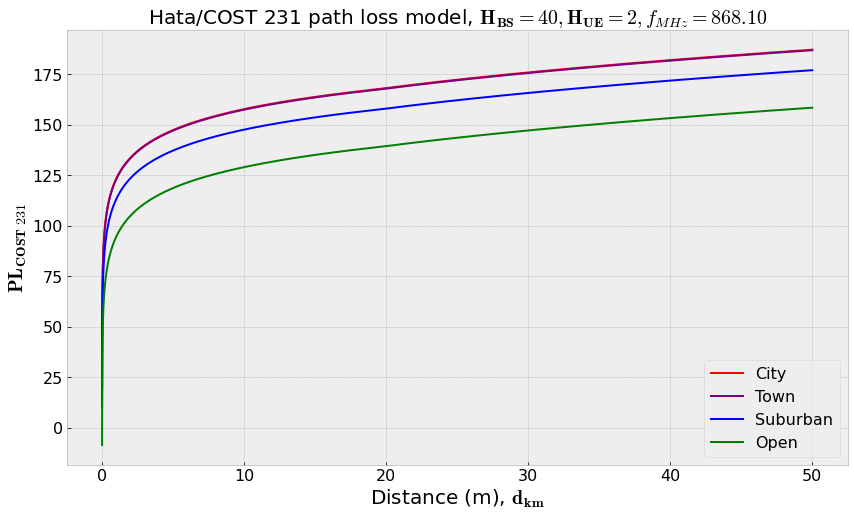

In [29]:
# COST 231 Extension to the Okumura-Hata model
# For LoRa / TS-UNB Uplink:
#f_MHz = 868.10 # MHz
f_MHz = 880.09
d_km = 1 # km
npd_km = np.arange(0.001,50.001,0.001) # km
#print(npd_km)
h_UE = 2 # meter
h_BS = 40 # meter

# Correction factors for UE antenna height
if 150 < f_MHz and f_MHz < 200:
    a_hUE_city = 8.3 * (math.log10(1.54 * h_UE))**2 - 1.1
else:
    a_hUE_city = 3.2 * (math.log10(11.75 * h_UE))**2 - 5.0 # Must be within 200 MHz < f_MHz < 1500 MHz.

a_hUE_town = 0.8 + (1.1 * math.log10(f_MHz) - 0.7) * h_UE - (1.56 * math.log10(f_MHz))

#print("a_hUE_city: ", a_hUE_city)
#print("a_hUE_town: ", a_hUE_town)

a_hUE_suburban = a_hUE_town + 2 * (math.log10(f_MHz/28))**2 + 5.4
a_hUE_open = a_hUE_town + 4.78 * (math.log10(f_MHz))**2 - (18.3 * math.log10(f_MHz)) + 40.9

A = 69.55 + 26.16 * math.log10(f_MHz) - 13.82 * math.log10(h_BS) 
B = (44.9 - 6.55 * math.log10(h_BS))

PL_COST231_city = []
PL_COST231_town = []
PL_COST231_suburban = []
PL_COST231_open = []

for i in npd_km:
    if i <= 20:
        beta = 1
    else:
        beta = 1 + (0.14 + 1.87 * 10**(-4) * f_MHz + 0.00107 * h_BS) * (math.log10(i/20))**0.8 # valid for distances betwee 20 and 100 km
    PL_COST231_city.append(A - a_hUE_city + B * (math.log10(i))**beta)
    PL_COST231_town.append(A - a_hUE_town + B * (math.log10(i))**beta)
    PL_COST231_suburban.append(A - a_hUE_suburban + B * (math.log10(i))**beta)
    PL_COST231_open.append(A - a_hUE_open + B * (math.log10(i))**beta)
    
#print("Beta is: {}".format(beta))

PL_COST231_city_1km = A - a_hUE_city + B * (math.log10(d_km))**beta
PL_COST231_town_1km = A - a_hUE_town + B * (math.log10(d_km))**beta
PL_COST231_suburban_1km = A - a_hUE_suburban + B * (math.log10(d_km))**beta
PL_COST231_open_1km = A - a_hUE_open + B * (math.log10(d_km))**beta

print("COST/Hata 312 path-loss @ {}km for:".format(d_km))
print("urban city: {:.2f} (dB)".format(PL_COST231_city_1km))
print("urban town: {:.2f} (dB)".format(PL_COST231_town_1km))
print("suburban area: {:.2f} (dB)".format(PL_COST231_suburban_1km))
print("rural/open areas: {:.2f} (dB)".format(PL_COST231_open_1km))
print("\n")

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig = plt.figure(figsize=(14,8))  
ax = fig.add_subplot(111)  
ax.plot(npd_km, PL_COST231_city, color="red", label='City')
ax.plot(npd_km, PL_COST231_town, color="purple", label='Town')
ax.plot(npd_km, PL_COST231_suburban, color="blue", label='Suburban')
ax.plot(npd_km, PL_COST231_open, color="green", label='Open')
ax.set_xlabel('Distance (m), $\mathbf{d_{km}}$', fontsize=20) #, weight='bold')  
ax.set_ylabel('$\mathbf{PL_{COST\ 231}}$', color='k',fontsize=20)  
ax.set_title("Hata/COST 231 path loss model, $\mathbf{H_{BS}=40, H_{UE}=2}, f_{MHz}=868.10$", fontsize=20);
#ax.set_xlim([-5,15])
#ax.set_ylim([0.000000000001,0])
ax.legend(fontsize=16) #, loc='lower center')
plt.show()

In [30]:
# Compare NB-IoT APL to Hata/COST 231 here
# NB-IoT:
#APL Min: 134.9
#APL max: 152.0

temp_ana = {'ind': 0, 'PL': 0}
temp_mes = {'ind': 0, 'PL': 0}

for i, j in enumerate(PL_COST231_open):
    if j <= 134.9:
        #print("i:", i, "j: ", j)
        #temp_ana.append(i)
        temp_ana['ind'] = i
        temp_ana['PL'] = j
    if j <= 152.0:
        #temp_mes.append(i)
        temp_mes['ind'] = i
        temp_mes['PL'] = j

#print("temp_ana:", temp_ana)        
#print("temp_mes:", temp_mes)

d_ana = npd_km[temp_ana['ind']]
d_mes = npd_km[temp_mes['ind']]
print("D for PL of 134.9 dB: {:.2f} km".format(d_ana))
print("D for PL of 152.0 dB: {:.2f} km".format(d_mes))

D for PL of 134.9 dB: 14.74 km
D for PL of 152.0 dB: 37.57 km


In [31]:
# TS-UNB:
#APL Analytical: 129.7
#APL Measured: 126.0

temp_ana = {'ind': 0, 'PL': 0}
temp_mes = {'ind': 0, 'PL': 0}

for i, j in enumerate(PL_COST231_open):
    if j <= 129.7:
        #print("i:", i, "j: ", j)
        #temp_ana.append(i)
        temp_ana['ind'] = i
        temp_ana['PL'] = j
    if j <= 126.0:
        #temp_mes.append(i)
        temp_mes['ind'] = i
        temp_mes['PL'] = j

#print("temp_ana:", temp_ana)        
#print("temp_mes:", temp_mes)

d_ana = npd_km[temp_ana['ind']]
d_mes = npd_km[temp_mes['ind']]
print("D for PL of 129.7 dB: {:.2f} km".format(d_ana))
print("D for PL of 126.0 dB: {:.2f} km".format(d_mes))

D for PL of 129.7 dB: 10.41 km
D for PL of 126.0 dB: 8.12 km


In [32]:
# LoRaWAN:
APL = [139.0, 141.5, 144.0, 146.5, 149.0, 151.5, 154.0]

temp_ana = []
d_ana = []
#print(PL_COST231_open[-1])
for k, l in enumerate(APL):
    temp_ana.append({'ind': 0, 'PL': 0})
    for i, j in enumerate(PL_COST231_open):
        if j <= l:
            #print("i:", i, "j: ", j)
            #temp_ana.append(i)
            temp_ana[k]['ind'] = i
            temp_ana[k]['PL'] = j
    d_ana.append(round(npd_km[temp_ana[k]['ind']], 1))
print("d_ana:", d_ana)        

#print("\nAPL table, dB:\n", tabulate(d_ana, floatfmt=".1f"))


#print("D for PL of 126.7 dB: {:.2f} km".format(d_ana))

d_ana: [19.4, 22.3, 25.4, 28.9, 32.6, 36.7, 41.1]


In [33]:
T = 290 # Kelvin
B = 15000*12
k = Boltzmann
NF = 3

log_B = np.log10(B)

print("Channel bandwidth in dB: ", log_B)

print("Boltzmann:", k)

P_NT = 10 * np.log10(k*T/0.001) # 1 mW
P_NT2 = 10 * np.log10(k*T*1000) # 1000 mW, 2-ways apparently
print("Thermal Noise:")
print(P_NT)
print(P_NT2)
print("\n")

P_N = 10 * np.log10(k*T*B*1000) # 1000 mW, 2-ways apparently
print("Noise Power:")
print(P_N)
print("\n")

print("Effective Noise Power:")
P_Neff = P_N + NF
print(P_Neff)
print("\n")


Channel bandwidth in dB:  5.2552725051033065
Boltzmann: 1.380649e-23
Thermal Noise:
-173.97518719422808
-173.97518719422808


Noise Power:
-121.42246214319505


Effective Noise Power:
-118.42246214319505




In [34]:
# Calculating Peak Physical Data Rate R_PhyP for each TBS index
N_rep = 1 # 1 repetition
T_RU_12 = 1 # ms with 12 subcarriers
N_RU_min = [1, 2, 3, 4, 5, 6, 8, 10]
T_min12 = []

for i in N_RU_min:
    T_min12.append(N_rep * i * T_RU_12)
#print("T_min12: ", T_min12)
    
    
I_TBS = [[16, 32, 56, 88, 120, 152, 208, 256],
         [24, 56, 88, 144, 176, 208, 256, 344],
         [32, 72, 144, 176, 208, 256, 328, 424],
         [40, 104, 176, 208, 256, 328, 440, 568],
         [56, 120, 208, 256, 328, 408, 552, 680],
         [72, 144, 224, 328, 424, 504, 680, 872],
         [88, 176, 256, 392, 504, 600, 808, 1000],
         [104, 224, 328, 472, 584, 712, 1000, 1224],
         [120, 256, 392, 536, 680, 808, 1096, 1384],
         [136, 296, 456, 616, 776, 936, 1256, 1544],
         [144, 328, 504, 680, 872, 1000, 1384, 1736],
         [176, 376, 584, 776, 1000, 1192, 1608, 2024],
         [208, 440, 680, 1000, 1128, 1352, 1800, 2280],
         [224, 488, 744, 1032, 1256, 1544, 2024, 2536]]

R_PhyP = []

#print(I_TBS[7][2])

for i in range(len(I_TBS)):
    #print("\nMCS index, i: {}".format(i))
    R_PhyP.append([])
    for j in range(len(I_TBS[i])):
        R_PhyP[i].append(round((I_TBS[i][j]+24)/T_min12[j], 1)) # 24 bit CRC
        #print("j: {}, I_TBS value/T_min12: {}/{}, R_PhyP: {}".format(j, I_TBS[i][j], T_min12[j], R_PhyP[i][j]))
        
    #print(R_PhyP)

print("R_PhyP table (kbps):\n", tabulate(R_PhyP, floatfmt=".1f"))

# Calculating Physical data rate:

# Adding scheduling cycle overhead from
#      NPDCCH DCI/(NACK) = N_rep * 1 ms
#      Transmission Gap after DL = 8 ms
#      Transmission Gap after UL = 3 ms

T_SigOvh_min12 = []

for i in N_RU_min:
    T_SigOvh_min12.append(N_rep * i * T_RU_12 + 1 + 8 + 3)
#print("T_min12: ", T_min12)

R_Phy = []

for i in range(len(I_TBS)):
    #print("\nMCS index, i: {}".format(i))
    R_Phy.append([])
    for j in range(len(I_TBS[i])):
        R_Phy[i].append(round((I_TBS[i][j]+24)/T_SigOvh_min12[j], 1))
        #print("j: {}, I_TBS value/T_SigOvh_min12: {}/{}, R_PhyP: {}".format(j, I_TBS[i][j], T_SigOvh_min12[j], R_Phy[i][j]))

print("\nR_Phy table (kbps):\n", tabulate(R_Phy, floatfmt=".1f"))


# Calculating MAC-layer data rate:

# Deducting PDCP, RLC and MAC layer overheads from each TBS

#      PDCP: 1 Byte
#      RLC: 2 Bytes
#      MAC: 2 Bytes

R_MAC = []

for i in range(len(I_TBS)):
    #print("\nMCS index, i: {}".format(i))
    R_MAC.append([])
    for j in range(len(I_TBS[i])):
        R_MAC[i].append(round((I_TBS[i][j]-8*(1+2+2)+24)/T_SigOvh_min12[j], 1))
        #print("j: {}, I_TBS value - OVH / T_SigOvh_min12: {}/{}, R_MAC: {}".format(j, I_TBS[i][j], T_SigOvh_min12[j], R_MAC[i][j]))

print("\nR_MAC table (kbps):\n", tabulate(R_MAC, floatfmt=".1f"))


R_PhyP table (kbps):
 -----  -----  -----  -----  -----  -----  -----  -----
 40.0   28.0   26.7   28.0   28.8   29.3   29.0   28.0
 48.0   40.0   37.3   42.0   40.0   38.7   35.0   36.8
 56.0   48.0   56.0   50.0   46.4   46.7   44.0   44.8
 64.0   64.0   66.7   58.0   56.0   58.7   58.0   59.2
 80.0   72.0   77.3   70.0   70.4   72.0   72.0   70.4
 96.0   84.0   82.7   88.0   89.6   88.0   88.0   89.6
112.0  100.0   93.3  104.0  105.6  104.0  104.0  102.4
128.0  124.0  117.3  124.0  121.6  122.7  128.0  124.8
144.0  140.0  138.7  140.0  140.8  138.7  140.0  140.8
160.0  160.0  160.0  160.0  160.0  160.0  160.0  156.8
168.0  176.0  176.0  176.0  179.2  170.7  176.0  176.0
200.0  200.0  202.7  200.0  204.8  202.7  204.0  204.8
232.0  232.0  234.7  256.0  230.4  229.3  228.0  230.4
248.0  256.0  256.0  264.0  256.0  261.3  256.0  256.0
-----  -----  -----  -----  -----  -----  -----  -----

R_Phy table (kbps):
 ----  ----  ----  ----  ----  ----  -----  -----
 3.1   4.0   5.3   7.0   8.

In [35]:
# Channel Duty cycle analysis of LoRaWAN:
# 8 Channels, BW 125 kHz, EU865-868 & EU870-875.6 MHz – DC 1 %

# Select interval
INT = 3000 # ms
#INT = 15000 # ms
#INT = 60000 # ms
#INT = 600000 # ms

# Simulation run time
T_obs = 3600000 # ms, 1h

#Channels
NoCHs = 8 # EU

#Duty Cycle
DC = 0.01 # 1 % Duty Cycle for EU

# Define message as packets T_ON times in milliseconds. 324.864 ms = Full Frame
T_ON = [324.864, 324.864, 324.864, 324.864, 226.56] # P1a
#T_ON = [214.272] # P1b
#T_ON = [181.504] # P2
#T_ON = [62.72] # Control (ReqJoin)
T_WAIT = INT - np.sum(T_ON)

# T_OFF timer is: T_OFF = T_ON / DC

# Preparations
chs_T_OFF = np.zeros((NoCHs,), dtype=int) # format with 0s
chs_T_OFF = chs_T_OFF.tolist() # to python list
ch_ind = 0
tx_ind = 0
prev_T = 0
result = 0
SIM_timer = 0

# Run simulation
print("Total packets run in simulation:", np.floor(T_obs/INT))
while SIM_timer != np.floor(T_obs/INT): # no. packets
    print("Packet no. ", SIM_timer)
    print("\tVariables before packet.\n\tch_ind: {}, tx_ind: {}, chs_T_OFF: {}.".format(ch_ind, tx_ind, chs_T_OFF))
    # Conditions for next round. Atleast one channel must have T_OFF = 0:
    if min(chs_T_OFF) != 0:
        result = 2
        #print("\tNo channels with T_OFF = 0")
        #print("\tbreaking")
        break
    
    # Send packet:
    #print("ch_ind: ", ch_ind)
    #print("\tTransmitting packet tx_ind: ", tx_ind)
    chs_T_OFF[ch_ind] += T_ON[tx_ind]/DC
    #print("\tchs_T_OFF[", ch_ind, "]: ", chs_T_OFF[ch_ind])
    # Deduct current packet tx time from T_OFF timers except for channel where just sent (ch_ind) and if already = 0
    #print("\tStarting deduction for-loop.")
    for ind, value in enumerate(chs_T_OFF):
        #print("\tT_OFF deduction. ind: ", ind, "value: ", value)
        if value == 0:
            #print("\t\tT_OFF was already 0. No deduction. continued")
            continue
        elif ind == ch_ind:
            #print("\t\tind was ch_ind: No deduction. continued")
            continue
        # Make sure T_OFF does not go negative
        elif value >= T_ON[tx_ind]:
            #print("\t\tDeducting current packet tx time from other ch T_OFF timers.")
            chs_T_OFF[ind] -= T_ON[tx_ind]
        else:
            chs_T_OFF[ind] = 0
    
    # EU specific, minimum T_OFF rule forced between each packet:
    #print("\tPacket sent. Deducting minimum T_OFF rule 100ms from all ch T_OFF timers.")
    for ind, value in enumerate(chs_T_OFF):
        #print("\tT_OFF deduction. ind: ", ind, "value: ", value)
        if value == 0:
            #print("\t\tT_OFF was already 0. No minT_OFF deduction. continued")
            continue
        elif value >= 100:
            #print("\t\tDeducting minimum T_OFF rule 100ms from ch{} T_OFF timer.".format(ind))
            chs_T_OFF[ind] -= 100
        else:
            #print("\t\tDeducting minimum T_OFF rule 100ms from ch{} T_OFF timer.".format(ind))
            chs_T_OFF[ind] = 0
    
    # If tx_ind == last packet, reduce wait time from all T_OFF timers, and loop back to first packet:
    # Wait time is the time between interval and end of last packet of message.
    #print("\ttx_ind is now: ", tx_ind, "index of last packet is: ", T_ON.index(T_ON[-1]))
    if tx_ind == T_ON.index(T_ON[-1]):
        #print("\t\tAll packets sent for message. Deducting wait time from all ch T_OFF timers.")
        for ind, value in enumerate(chs_T_OFF):
            if value == 0:
                continue
            elif value >= T_WAIT:
                chs_T_OFF[ind] -= T_WAIT
            else:
                chs_T_OFF[ind] = 0
        else:
            tx_ind = 0
            #print("\t\tLooping back to first packet. tx_ind is now:", tx_ind)
    else: 
        # Set next packet to send
        tx_ind += 1
    
    # For the next packet start with the channel with smallest T_OFF time
    # Find the position of the minimum value, search starts from begining of list
    ch_ind = chs_T_OFF.index(min(chs_T_OFF)) 
    #print("ch_ind: ", ch_ind)
    SIM_timer += 1
    #print("T_OFF after tx event ", SIM_timer, ": ", chs_T_OFF)
    print("\tVariables after packet.\n\tch_ind: {}, tx_ind: {}, chs_T_OFF: {}.\n".format(ch_ind, tx_ind, chs_T_OFF))    
    
if result == 2:
    print("\nDuty Cycle not feasible for chosen interval of ", int(INT/1000), "s")
    print("Duty Cycle limit forced additional wait time of {:.2f} ms after {:d} packets.".format(min(chs_T_OFF),SIM_timer))
else:
    print("\nDuty Cycle is feasible for chosen interval of: ", int(INT/1000), "s")

Total packets run in simulation: 1200.0
Packet no.  0
	Variables before packet.
	ch_ind: 0, tx_ind: 0, chs_T_OFF: [0, 0, 0, 0, 0, 0, 0, 0].
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [32386.399999999998, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1
	Variables before packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [32386.399999999998, 0, 0, 0, 0, 0, 0, 0].
	Variables after packet.
	ch_ind: 2, tx_ind: 2, chs_T_OFF: [31961.535999999996, 32386.399999999998, 0, 0, 0, 0, 0, 0].

Packet no.  2
	Variables before packet.
	ch_ind: 2, tx_ind: 2, chs_T_OFF: [31961.535999999996, 32386.399999999998, 0, 0, 0, 0, 0, 0].
	Variables after packet.
	ch_ind: 3, tx_ind: 3, chs_T_OFF: [31536.671999999995, 31961.535999999996, 32386.399999999998, 0, 0, 0, 0, 0].

Packet no.  3
	Variables before packet.
	ch_ind: 3, tx_ind: 3, chs_T_OFF: [31536.671999999995, 31961.535999999996, 32386.399999999998, 0, 0, 0, 0, 0].
	Variables after packet.
	ch_ind: 4, tx_ind: 4, chs_T_OFF: [31111.807999999994, 31536.671999999995

In [40]:
# Uplink Channel Duty Cycle analysis of LoRaWAN:
# 64 Channels, BW 125 kHz, US902-928 MHz

# Select interval
INT = 3000 # ms
#INT = 15000 # ms
#INT = 60000 # ms
#INT = 600000 # ms

# Simulation run time
T_obs = 3600000 # ms, 1h

# Channels
NoCHs = 64 # US, BW < 250 kHz
#noCHs = 8 # US, 250 < BW < 250 kHz

# Duty Cycle
DC = 0.02 # 2 % Duty Cycle for US, BW < 250kHz
#DC = 0.04 # 4 % Duty Cyclefor US, BW <= 500kHz

# Define message as packets T_ON times in milliseconds. 324.864 ms = Full Frame
T_ON = [324.864, 324.864, 324.864, 324.864, 226.56] # P1a
#T_ON = [214.272] # P1b
#T_ON = [181.504] # P2
#T_ON = [62.72] # Control (ReqJoin)
T_WAIT = INT - np.sum(T_ON)

# T_OFF timer is: T_OFF = T_ON / DC

# Preparations

# Preparations
chs_T_OFF = np.zeros((NoCHs,), dtype=int) # format with 0s
chs_T_OFF = chs_T_OFF.tolist() # to python list
ch_ind = 0
tx_ind = 0
prev_T = 0
result = 0
SIM_timer = 0

# Run simulation
print("Total packets run in simulation:", np.floor(T_obs/INT))
while SIM_timer != np.floor(T_obs/INT): # no. packets
    print("Packet no. ", SIM_timer)
    #print("\tVariables before packet.\n\tch_ind: {}, tx_ind: {}, chs_T_OFF: {}.".format(ch_ind, tx_ind, chs_T_OFF))
    # Conditions for next round. Atleast one channel must have T_OFF = 0:
    if min(chs_T_OFF) != 0:
        result = 2
        #print("\tNo channels with T_OFF = 0")
        #print("\tbreaking")
        break
    
    # Send packet:
    #print("ch_ind: ", ch_ind)
    #print("\tTransmitting packet tx_ind: ", tx_ind)
    chs_T_OFF[ch_ind] += T_ON[tx_ind]/DC
    #print("\tchs_T_OFF[", ch_ind, "]: ", chs_T_OFF[ch_ind])
    # Deduct current packet tx time from T_OFF timers except for channel where just sent (ch_ind) and if already = 0
    #print("\tStarting deduction for-loop.")
    for ind, value in enumerate(chs_T_OFF):
        #print("\tT_OFF deduction. ind: ", ind, "value: ", value)
        if value == 0:
            #print("\t\tT_OFF was already 0. No deduction. continued")
            continue
        elif ind == ch_ind:
            #print("\t\tind was ch_ind: No deduction. continued")
            continue
        # Make sure T_OFF does not go negative
        elif value >= T_ON[tx_ind]:
            #print("\t\tDeducting current packet tx time from other ch T_OFF timers.")
            chs_T_OFF[ind] -= T_ON[tx_ind]
        else:
            chs_T_OFF[ind] = 0
    
    # If tx_ind == last packet, reduce wait time from all T_OFF timers, and loop back to first packet:
    # Wait time is the time between interval and end of last packet of message.
    #print("\ttx_ind is now: ", tx_ind, "index of last packet is: ", T_ON_P1a.index(T_ON_P1a[-1]))
    if tx_ind == T_ON.index(T_ON[-1]):
        print("\t\tAll packets sent for message. Deducting wait time from all ch T_OFF timers.")
        for ind, value in enumerate(chs_T_OFF):
            if value == 0:
                continue
            elif value >= T_WAIT:
                chs_T_OFF[ind] -= T_WAIT
            else:
                chs_T_OFF[ind] = 0
        else:
            tx_ind = 0
            #print("\t\tLooping back to first packet. tx_ind is now:", tx_ind)
    else: 
        # Set next packet to send
        tx_ind += 1
    
    # For the next packet start with the channel with smallest T_OFF time
    # Find the position of the minimum value, search starts from begining of list
    ch_ind = chs_T_OFF.index(min(chs_T_OFF)) 
    #print("ch_ind: ", ch_ind)
    SIM_timer += 1
    #print("T_OFF after tx event ", SIM_timer, ": ", chs_T_OFF)
    print("\tVariables after packet.\n\tch_ind: {}, tx_ind: {}, chs_T_OFF: {}.\n".format(ch_ind, tx_ind, chs_T_OFF))    
    
if result == 2:
    print("\nDuty Cycle not feasible for chosen interval of ", INT)
    print("Duty Cycle forced additional wait time of {:.2f} ms after {:d} packets.".format(min(chs_T_OFF),SIM_timer))
else:
    print("\nDuty Cycle is feasible for chosen interval of: ", INT)

Total packets run in simulation: 1200.0
Packet no.  0
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1
	Variables after packet.
	ch_ind: 2, tx_ind: 2, chs_T_OFF: [15918.336, 16243.199999999999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  2
	Variables after packet.
	ch_ind: 3, tx_ind: 3, chs_T_OFF: [15593.472, 15918.336, 16243.199999999999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  3
	Variables after packet.
	ch_ind: 4, tx_ind: 4, chs_T_OFF: [15268.6

Packet no.  42
	Variables after packet.
	ch_ind: 13, tx_ind: 3, chs_T_OFF: [9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 4568.064000000005, 12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 7568.064000000004, 15593.472, 15918.336, 16243.199999999999, 0, 5879.424000000003, 593.472000000005, 918.336000000005, 1243.2000000000048, 1568.0640000000053, 8879.424, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 0, 6593.472000000005, 6918.336000000005, 7243.200000000004, 2879.4240000000023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  43
	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 4243.200000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 7243.200000000004, 15268.608, 15593.472, 15918.336, 16243.199999999999, 5554.560000000003, 268.608000000005, 

Packet no.  86
	Variables after packet.
	ch_ind: 24, tx_ind: 2, chs_T_OFF: [918.336000000005, 1243.200000000005, 1568.0640000000049, 1892.9280000000053, 12918.336000000001, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 15918.336, 6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 13243.2, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 16243.199999999999, 13568.064, 13892.928, 3204.2880000000023, 9204.288, 0, 0, 6204.288000000002, 204.2880000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  87
	Variables after packet.
	ch_ind: 25, tx_ind: 3, chs_T_OFF: [593.472000000005, 918.336000000005, 1243.2000000000048, 1568.0640000000053, 12593.472000000002, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 15593.472, 6593.472000000005, 6918.336000000005, 7243.200000000004, 7568.064000000004, 12918.336000

Packet no.  128
	Variables after packet.
	ch_ind: 27, tx_ind: 4, chs_T_OFF: [12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6918.336000000005, 7243.200000000004, 2554.560000000002, 8554.560000000001, 9918.336000000003, 10243.200000000003, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  129
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 10, tx_ind: 0, chs_T_OFF: [10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0, 

Packet no.  164
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 15, tx_ind: 0, chs_T_OFF: [7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 0, 0, 4892.928000000004, 2217.792000000005, 2542.6560000000054, 3854.0160000000024, 9854.016, 5217.792000000004, 5542.656000000004, 6854.016000000001, 854.0160000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  165
	Variables after packet.
	ch_ind: 16, tx_ind: 1, chs_T_OFF: [7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928000000002, 11217.792000000001, 4243.200000000005, 13243.2, 13568.064, 13892.928

Packet no.  203
	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 15268.608, 6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 15593.472, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.472000000005, 15918.336, 16243.199999999999, 5554.560000000003, 0, 918.3360000000048, 1243.2000000000053, 8554.560000000001, 2554.560000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  204
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 9, tx_ind: 0, chs_T_OFF: [1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.

Packet no.  239
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 0, tx_ind: 0, chs_T_OFF: [0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 10892.928000000002, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 11217.792000000001, 11542.656, 6854.016000000001, 854.0160000000021, 14217.792, 14542.655999999999, 9854.016, 3854.0160000000024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  240
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 10243.200000000003, 1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 10568.06400000

		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 0, tx_ind: 0, chs_T_OFF: [0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 10892.928000000002, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 11217.792000000001, 11542.656, 854.0160000000021, 6854.016000000001, 14217.792, 14542.655999999999, 3854.0160000000024, 9854.016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  270
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 10243.200000000003, 1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 10568.064000000002, 7243.20000

		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 854.0160000000021, 6854.016000000001, 2217.792000000005, 2542.6560000000054, 3854.0160000000024, 9854.016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  290
	Variables after packet.
	ch_ind: 14, tx_ind: 1, chs_T_OFF: [4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928


Packet no.  308
	Variables after packet.
	ch_ind: 27, tx_ind: 4, chs_T_OFF: [12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6918.336000000005, 7243.200000000004, 2554.560000000002, 8554.560000000001, 9918.336000000003, 10243.200000000003, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  309
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 10, tx_ind: 0, chs_T_OFF: [10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0,

Packet no.  333
	Variables after packet.
	ch_ind: 22, tx_ind: 4, chs_T_OFF: [15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 12268.608000000002, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 12593.472000000002, 9918.336000000003, 10243.200000000003, 0, 5554.560000000003, 12918.336000000001, 13243.2, 2554.560000000002, 8554.560000000001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  334
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 5, tx_ind: 0, chs_T_OFF: [13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.656000

Packet no.  359
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 0, tx_ind: 0, chs_T_OFF: [0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 10892.928000000002, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 11217.792000000001, 11542.656, 6854.016000000001, 854.0160000000021, 14217.792, 14542.655999999999, 9854.016, 3854.0160000000024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  360
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 10243.200000000003, 1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 10568.06400000

	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 15268.608, 6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 15593.472, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.472000000005, 15918.336, 16243.199999999999, 5554.560000000003, 0, 918.3360000000048, 1243.2000000000053, 8554.560000000001, 2554.560000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  384
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 9, tx_ind: 0, chs_T_OFF: [1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 78


Packet no.  409
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 854.0160000000021, 6854.016000000001, 2217.792000000005, 2542.6560000000054, 3854.0160000000024, 9854.016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  410
	Variables after packet.
	ch_ind: 14, tx_ind: 1, chs_T_OFF: [4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000

Packet no.  433
	Variables after packet.
	ch_ind: 22, tx_ind: 4, chs_T_OFF: [9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3918.3360000000052, 4243.200000000005, 0, 5554.560000000003, 6918.336000000005, 7243.200000000004, 2554.560000000002, 8554.560000000001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  434
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 15, tx_ind: 0, chs_T_OFF: [7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568

Packet no.  458
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6918.336000000005, 7243.200000000004, 8554.560000000001, 2554.560000000002, 9918.336000000003, 10243.200000000003, 0, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  459
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 10, tx_ind: 0, chs_T_OFF: [10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0, 


Packet no.  498
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.472000000005, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 918.3360000000048, 1243.2000000000053, 8554.560000000001, 2554.560000000002, 3918.3360000000052, 4243.200000000005, 0, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  499
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.0640000000

Packet no.  526
	Variables after packet.
	ch_ind: 17, tx_ind: 2, chs_T_OFF: [6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 918.336000000005, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 3918.3360000000052, 12918.336000000001, 13243.2, 13568.064, 13892.928, 1243.200000000005, 15918.336, 16243.199999999999, 0, 0, 4243.200000000005, 1568.0640000000049, 1892.9280000000053, 3204.2880000000023, 9204.288, 4568.064000000005, 4892.928000000004, 6204.288000000002, 204.2880000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  527
	Variables after packet.
	ch_ind: 18, tx_ind: 3, chs_T_OFF: [6593.472000000005, 6918.336000000005, 7243.200000000004, 7568.064000000004, 593.472000000005, 9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 3593.472000000005, 12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 918.336000000005, 1


Packet no.  559
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 6854.016000000001, 854.0160000000021, 2217.792000000005, 2542.6560000000054, 9854.016, 3854.0160000000024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  560
	Variables after packet.
	ch_ind: 14, tx_ind: 1, chs_T_OFF: [4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000

Packet no.  585
	Variables after packet.
	ch_ind: 16, tx_ind: 1, chs_T_OFF: [7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928000000002, 11217.792000000001, 4243.200000000005, 13243.2, 13568.064, 13892.928, 14217.792, 1568.064000000005, 16243.199999999999, 0, 0, 0, 4568.064000000005, 1892.9280000000049, 2217.7920000000054, 3529.1520000000023, 9529.152, 4892.928000000004, 5217.792000000004, 6529.152000000002, 529.1520000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  586
	Variables after packet.
	ch_ind: 17, tx_ind: 2, chs_T_OFF: [6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 918.336000000005, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 3918.3360000000052, 12918.336000000001, 13243.2, 13568.064, 13892.928, 1243.200000000005, 15918.336, 16243.19999

		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 0, tx_ind: 0, chs_T_OFF: [0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 10892.928000000002, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 11217.792000000001, 11542.656, 6854.016000000001, 854.0160000000021, 14217.792, 14542.655999999999, 9854.016, 3854.0160000000024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  600
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 10243.200000000003, 1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 10568.064000000002, 7243.20000

Packet no.  617
	Variables after packet.
	ch_ind: 18, tx_ind: 3, chs_T_OFF: [6593.472000000005, 6918.336000000005, 7243.200000000004, 7568.064000000004, 593.472000000005, 9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 3593.472000000005, 12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 918.336000000005, 15593.472, 15918.336, 16243.199999999999, 0, 3918.3360000000052, 1243.2000000000048, 1568.0640000000053, 8879.424, 2879.4240000000023, 4243.200000000005, 4568.064000000005, 0, 5879.424000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  618
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.472000000


Packet no.  649
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 854.0160000000021, 6854.016000000001, 2217.792000000005, 2542.6560000000054, 3854.0160000000024, 9854.016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  650
	Variables after packet.
	ch_ind: 14, tx_ind: 1, chs_T_OFF: [4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000

Packet no.  678
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.472000000005, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 918.3360000000048, 1243.2000000000053, 8554.560000000001, 2554.560000000002, 3918.3360000000052, 4243.200000000005, 0, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  679
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 4, tx_ind: 0, chs_T_OFF: [4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.06400000000


Packet no.  702
	Variables after packet.
	ch_ind: 13, tx_ind: 3, chs_T_OFF: [9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 3593.472000000005, 12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 6593.472000000005, 15593.472, 15918.336, 16243.199999999999, 0, 3918.3360000000052, 593.472000000005, 918.336000000005, 1243.2000000000048, 1568.0640000000053, 6918.336000000005, 4243.200000000005, 4568.064000000005, 5879.424000000003, 0, 7243.200000000004, 7568.064000000004, 8879.424, 2879.4240000000023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  703
	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 268.60800000000

		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 9, tx_ind: 0, chs_T_OFF: [1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 14217.792, 14542.655999999999, 3854.0160000000024, 9854.016, 0, 0, 6854.016000000001, 854.0160000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  745
	Variables after packet.
	ch_ind: 19, tx_ind: 1, chs_T_OFF: [1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 


Packet no.  827
	Variables after packet.
	ch_ind: 18, tx_ind: 3, chs_T_OFF: [6593.472000000005, 6918.336000000005, 7243.200000000004, 7568.064000000004, 593.472000000005, 9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 3593.472000000005, 12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 918.336000000005, 15593.472, 15918.336, 16243.199999999999, 0, 3918.3360000000052, 1243.2000000000048, 1568.0640000000053, 2879.4240000000023, 8879.424, 4243.200000000005, 4568.064000000005, 5879.424000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  828
	Variables after packet.
	ch_ind: 27, tx_ind: 4, chs_T_OFF: [6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 268.608000000005, 9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 593.47200000

Packet no.  843
	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 12268.608000000002, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6268.608000000006, 6593.472000000005, 6918.336000000005, 7243.200000000004, 12593.472000000002, 9918.336000000003, 10243.200000000003, 5554.560000000003, 0, 12918.336000000001, 13243.2, 8554.560000000001, 2554.560000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  844
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 5, tx_ind: 0, chs_T_OFF: [13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0, 0, 10568.064000000002, 1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.656000

Packet no.  871
	Variables after packet.
	ch_ind: 2, tx_ind: 2, chs_T_OFF: [15918.336, 16243.199999999999, 0, 0, 9918.336000000003, 918.336000000005, 1243.200000000005, 1568.0640000000049, 1892.9280000000053, 12918.336000000001, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 10243.200000000003, 6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 13243.2, 10568.064000000002, 10892.928000000002, 204.2880000000021, 6204.288000000002, 13568.064, 13892.928, 3204.2880000000023, 9204.288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  872
	Variables after packet.
	ch_ind: 3, tx_ind: 3, chs_T_OFF: [15593.472, 15918.336, 16243.199999999999, 0, 9593.472000000003, 593.472000000005, 918.336000000005, 1243.2000000000048, 1568.0640000000053, 12593.472000000002, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 9918.336000000003, 6593.47200000000


Packet no.  906
	Variables after packet.
	ch_ind: 7, tx_ind: 2, chs_T_OFF: [12918.336000000001, 13243.2, 13568.064, 13892.928, 6918.336000000005, 15918.336, 16243.199999999999, 0, 0, 9918.336000000003, 918.336000000005, 1243.200000000005, 1568.0640000000049, 1892.9280000000053, 7243.200000000004, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 10243.200000000003, 7568.064000000004, 7892.9280000000035, 3204.2880000000023, 9204.288, 10568.064000000002, 10892.928000000002, 6204.288000000002, 204.2880000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  907
	Variables after packet.
	ch_ind: 8, tx_ind: 3, chs_T_OFF: [12593.472000000002, 12918.336000000001, 13243.2, 13568.064, 6593.472000000005, 15593.472, 15918.336, 16243.199999999999, 0, 9593.472000000003, 593.472000000005, 918.336000000005, 1243.2000000000048, 1568.0640000000053, 6918.336000000005, 3593.472000000005, 3918.336000000

Packet no.  944
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 15, tx_ind: 0, chs_T_OFF: [7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 1892.928000000005, 0, 0, 0, 0, 4892.928000000004, 2217.792000000005, 2542.6560000000054, 3854.0160000000024, 9854.016, 5217.792000000004, 5542.656000000004, 6854.016000000001, 854.0160000000021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  945
	Variables after packet.
	ch_ind: 16, tx_ind: 1, chs_T_OFF: [7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928000000002, 11217.792000000001, 4243.200000000005, 13243.2, 13568.064, 13892.928

Packet no.  960
	Variables after packet.
	ch_ind: 1, tx_ind: 1, chs_T_OFF: [16243.199999999999, 0, 0, 0, 10243.200000000003, 1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 10568.064000000002, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 13568.064, 10892.928000000002, 11217.792000000001, 6529.152000000002, 529.1520000000021, 13892.928, 14217.792, 9529.152, 3529.1520000000023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  961
	Variables after packet.
	ch_ind: 2, tx_ind: 2, chs_T_OFF: [15918.336, 16243.199999999999, 0, 0, 9918.336000000003, 918.336000000005, 1243.200000000005, 1568.0640000000049, 1892.9280000000053, 12918.336000000001, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 10243.200000000003, 6918.336000000005, 7243.200000000004, 

Packet no.  1003
	Variables after packet.
	ch_ind: 23, tx_ind: 4, chs_T_OFF: [9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3918.3360000000052, 4243.200000000005, 5554.560000000003, 0, 6918.336000000005, 7243.200000000004, 8554.560000000001, 2554.560000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1004
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 15, tx_ind: 0, chs_T_OFF: [7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 45

	Variables after packet.
	ch_ind: 14, tx_ind: 1, chs_T_OFF: [4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928000000002, 11217.792000000001, 0, 13243.2, 13568.064, 13892.928, 14217.792, 1568.064000000005, 0, 0, 6529.152000000002, 529.1520000000021, 1892.9280000000049, 2217.7920000000054, 9529.152, 3529.1520000000023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1041
	Variables after packet.
	ch_ind: 20, tx_ind: 2, chs_T_OFF: [3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 15918.336, 6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 918.336000000005, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 16243.199999999999, 12918.336000000001,


Packet no.  1071
	Variables after packet.
	ch_ind: 20, tx_ind: 2, chs_T_OFF: [3918.3360000000052, 4243.200000000005, 4568.064000000005, 4892.928000000004, 15918.336, 6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 918.336000000005, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 16243.199999999999, 12918.336000000001, 13243.2, 13568.064, 13892.928, 1243.200000000005, 0, 0, 204.2880000000021, 6204.288000000002, 1568.0640000000049, 1892.9280000000053, 3204.2880000000023, 9204.288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1072
	Variables after packet.
	ch_ind: 21, tx_ind: 3, chs_T_OFF: [3593.472000000005, 3918.3360000000052, 4243.200000000005, 4568.064000000005, 15593.472, 6593.472000000005, 6918.336000000005, 7243.200000000004, 7568.064000000004, 593.472000000005, 9593.472000000003, 9918.336000000003, 10243.200000000003, 10568.064000000002, 15918.3

Packet no.  1093
	Variables after packet.
	ch_ind: 22, tx_ind: 4, chs_T_OFF: [9268.608000000004, 9593.472000000003, 9918.336000000003, 10243.200000000003, 3268.608000000005, 12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 3593.472000000005, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3918.3360000000052, 4243.200000000005, 0, 5554.560000000003, 6918.336000000005, 7243.200000000004, 2554.560000000002, 8554.560000000001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1094
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 15, tx_ind: 0, chs_T_OFF: [7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 1568.064000000005, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 45

Packet no.  1118
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6918.336000000005, 7243.200000000004, 8554.560000000001, 2554.560000000002, 9918.336000000003, 10243.200000000003, 0, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1119
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 10, tx_ind: 0, chs_T_OFF: [10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0

Packet no.  1134
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 9, tx_ind: 0, chs_T_OFF: [1568.064000000005, 1892.928000000005, 2217.792000000005, 2542.6560000000054, 13568.064, 4568.064000000005, 4892.928000000004, 5217.792000000004, 5542.656000000004, 0, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 8542.656000000003, 13892.928, 10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 0, 14217.792, 14542.655999999999, 9854.016, 3854.0160000000024, 0, 0, 854.0160000000021, 6854.016000000001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1135
	Variables after packet.
	ch_ind: 19, tx_ind: 1, chs_T_OFF: [1243.200000000005, 1568.064000000005, 1892.9280000000049, 2217.7920000000054, 13243.2, 4243.200000000005, 4568.064000000005, 4892.928000000004, 5217.792000000004, 16243.199999999999, 7243.200000000004, 7568.064000000004, 78

Packet no.  1155
	Variables after packet.
	ch_ind: 16, tx_ind: 1, chs_T_OFF: [7243.200000000004, 7568.064000000004, 7892.9280000000035, 8217.792000000003, 1243.200000000005, 10243.200000000003, 10568.064000000002, 10892.928000000002, 11217.792000000001, 4243.200000000005, 13243.2, 13568.064, 13892.928, 14217.792, 1568.064000000005, 16243.199999999999, 0, 0, 0, 4568.064000000005, 1892.9280000000049, 2217.7920000000054, 9529.152, 3529.1520000000023, 4892.928000000004, 5217.792000000004, 529.1520000000021, 6529.152000000002, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1156
	Variables after packet.
	ch_ind: 17, tx_ind: 2, chs_T_OFF: [6918.336000000005, 7243.200000000004, 7568.064000000004, 7892.9280000000035, 918.336000000005, 9918.336000000003, 10243.200000000003, 10568.064000000002, 10892.928000000002, 3918.3360000000052, 12918.336000000001, 13243.2, 13568.064, 13892.928, 1243.200000000005, 15918.336, 16243.199

Packet no.  1178
	Variables after packet.
	ch_ind: 26, tx_ind: 4, chs_T_OFF: [12268.608000000002, 12593.472000000002, 12918.336000000001, 13243.2, 6268.608000000006, 15268.608, 15593.472, 15918.336, 16243.199999999999, 9268.608000000004, 268.608000000005, 593.472000000005, 918.3360000000048, 1243.2000000000053, 6593.472000000005, 3268.608000000005, 3593.472000000005, 3918.3360000000052, 4243.200000000005, 9593.472000000003, 6918.336000000005, 7243.200000000004, 8554.560000000001, 2554.560000000002, 9918.336000000003, 10243.200000000003, 0, 5554.560000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

Packet no.  1179
		All packets sent for message. Deducting wait time from all ch T_OFF timers.
	Variables after packet.
	ch_ind: 10, tx_ind: 0, chs_T_OFF: [10568.064000000002, 10892.928000000002, 11217.792000000001, 11542.656, 4568.064000000005, 13568.064, 13892.928, 14217.792, 14542.655999999999, 7568.064000000004, 0, 0, 0

In [205]:
# NB-IoT Activity state period analysis for T_RX, T_Idle and T_Sleep_PSM
# T_Sleep is an alternative additional counter for the case that the UE can go to a "light" sleep state during DRX idle time.
# Derived from DRX rules as specified for NB-IoT
# Calculation valid if Message interval is less or equal to TAU Timer T3412
# System Frame Number (SFN) and Hyper SFN (H-SFN) tracking starts from zero at RRC Release.
# Long C-DRX only, currently.
# I-eDRX only, currently.
# Repetitions are not considered.
# Default for FDD.

# -------- Initialization --------
# Parameters for timers:
TX_RX_gap = 3 # ms
RF = 10 # ms, RadioFrame (RF)
SF = 1 # ms, SubFrame (SF)

T_TX = [{"P1a": 40, "P1b": 4, "P2": 4}, # 3s
        {"P1a": 40, "P1b": 4, "P2": 4}, # 15s
        {"P1a": 40, "P1b": 4, "P2": 4}, # 60s
        {"P1a": 40, "P1b": 4, "P2": 4}  # 600s
        ] # ms
T_RX = [{"P1a": 4, "P1b": 1, "P2": 1}, # 3s
        {"P1a": 4, "P1b": 1, "P2": 1}, # 15s
        {"P1a": 4, "P1b": 1, "P2": 1}, # 60s
        {"P1a": 4, "P1b": 1, "P2": 1}  # 600s
        ] # ms
T_Idle = [{"P1a": TX_RX_gap, "P1b": TX_RX_gap, "P2": TX_RX_gap}, # 3s
          {"P1a": TX_RX_gap, "P1b": TX_RX_gap, "P2": TX_RX_gap}, # 15s
          {"P1a": TX_RX_gap, "P1b": TX_RX_gap, "P2": TX_RX_gap}, # 60s
          {"P1a": TX_RX_gap, "P1b": TX_RX_gap, "P2": TX_RX_gap}  # 600s
          ] # ms
T_Sleep = [{"P1a": 0, "P1b": 0, "P2": 0}, # 3s
           {"P1a": 0, "P1b": 0, "P2": 0}, # 15s
           {"P1a": 0, "P1b": 0, "P2": 0}, # 60s
           {"P1a": 0, "P1b": 0, "P2": 0}  # 600s
           ] # ms
T_Sleep_PSM = [{"P1a": 0, "P1b": 0, "P2": 0}, # 3s
           {"P1a": 0, "P1b": 0, "P2": 0}, # 15s
           {"P1a": 0, "P1b": 0, "P2": 0}, # 60s
           {"P1a": 0, "P1b": 0, "P2": 0}  # 600s
           ] # ms, PSM

intervals = [3000, 15000, 60000, 600000] # Max. 4. Atleast until implement dynamic building of msg_int_rem.
# 3 second msg interval. 3000 - 40 - 3 - 4 = 2953 ms,(Interval - msg_TX - TX/RX_switch_gap - Ack_RX) 
# 15 second msg interval. 15000 - 40 - 3 - 4 = 14953 ms
# 60 second msg interval. 60000 - 40 - 3 - 4 = 59953 ms
# 600 second msg interval. 600000 - 40 - 3 - 4 = 599953 ms
msg_int_rem = [{"P1a": intervals[0] - T_TX[0]["P1a"] - TX_RX_gap -T_RX[0]["P1a"], # 3s
            "P1b": intervals[0] - T_TX[0]["P1b"] - TX_RX_gap -T_RX[0]["P1b"], 
            "P2": intervals[0] - T_TX[0]["P2"] - TX_RX_gap -T_RX[0]["P2"]}, 
           {"P1a": intervals[1] - T_TX[1]["P1a"] - TX_RX_gap -T_RX[1]["P1a"], # 15s
            "P1b": intervals[1] - T_TX[1]["P1b"] - TX_RX_gap -T_RX[1]["P1b"], 
            "P2": intervals[1] - T_TX[1]["P2"] - TX_RX_gap -T_RX[1]["P2"]}, 
           {"P1a": intervals[2] - T_TX[2]["P1a"] - TX_RX_gap -T_RX[2]["P1a"], # 60s
            "P1b": intervals[2] - T_TX[2]["P1b"] - TX_RX_gap -T_RX[2]["P1b"], 
            "P2": intervals[2] - T_TX[2]["P2"] - TX_RX_gap -T_RX[2]["P2"]}, 
           {"P1a": intervals[3] - T_TX[3]["P1a"] - TX_RX_gap -T_RX[3]["P1a"], # 600s
            "P1b": intervals[3] - T_TX[3]["P1b"] - TX_RX_gap -T_RX[3]["P1b"], 
            "P2": intervals[3] - T_TX[3]["P2"] - TX_RX_gap -T_RX[3]["P2"]}] # in ms  
print("msg_int_rem", msg_int_rem)

# RRC_Connected
# ----
# RRC Inactivity Timer. RRC Release performed at expiry.
T_RRC_IA = RF*0 # RFs. 
# ----
# DRX Inactivity Timer. Runs prior to C-DRX cycles. 
# Valid values: psf1, psf2, psf3, psf4, psf5, psf6, psf8, psf10, psf20, psf30, psf40, psf50, psf60, psf80, psf100, psf200, psf300, psf500, psf750, psf1280, psf1920, psf2560
T_DRX_IA = SF*8 # SFs, 8 ms. Can have values in 2^x ms, where x ∈ {0,...,14}
# ----
# DRX Inactivity Timer with C-eDRX. Runs prior to C-eDRX cycles. 
# Valid values: 0, 1, 2, 3, 4, 8, 16, 32
T_eDRX_IA = SF*8 # SFs, 8 ms.
# ----
# OnDuration. Duration while actively receiving during C-DRX cycle in RRC Connected state.
# Valid values: psf1, psf2, psf3, psf4, psf5, psf6, psf8, psf10, psf20, psf30, psf40, psf8, psf10, psf20, psf30, psf40, psf50, psf60, psf80, psf100, psf200
OnDur_DRX= SF*4 # SFs, 4 ms.
# ----
# OnDuration. Duration while actively receiving during C-eDRX cycle in RRC Connected state.
# Valid values: 1, 2, 3, 4, 8, 16, 32
OnDur_eDRX = SF*4 # SFs, 4 ms.
# ----
# Long C-DRX cycle length.
# Valid values: sf10, sf20, sf32, sf40, sf60, sf64, sf70, sf80, sf128, sf160, sf256, sf320, sf512, sf640, sf1024, sf1280, sf2048, sf2560
T_LCDRX = SF*256 # SFs, 256 ms.
# ----
# Long C-eDRX cycle length.
# Valid values: sf256, sf512, sf1024, sf1536, sf2048, sf3072, sf4096, sf4608, sf6144, sf7680, sf8192, sf9216 
T_LCeDRX = SF*1024 # SFs, 1024 ms.

# RRC_Idle
# ----
# Number of I-eDRX cycles
# to make up the Active Timer (T3324). 0 to disable I-eDRX in this calculation
N_IeDRX = 2
# ----
# I-eDRX cycle length.
# Valid values: duration of hyper RadioFrames (1024 RFs) by 2^x RFs, where x ∈ {11, ..., 20}:
# 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576
T_IeDRX = RF*2048 # 20480 ms, 
# ----
# Paging Window Timer
# Once within eDRX cycle. MUST BE LESS THAN I-eDRX CYCLE!
# Valid values if RFs: 256, 512, 768, 1024, 1280, 1536, 1792, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096
T_PW = RF*512 # 5120 ms
# ----
# I-DRX cycle length.
# Valid values: 128, 256, 512 or 1024 RFs.
T_IDRX = RF*128 # 1280 ms, 0 to disable in this calculation
# ----
# Number of I-DRX cycles
# within PTW or to make up the Active Timer (T3324)
# From TS 136 304 chapter 7.1 and 7.3
IMSI = 310170845466094 # international mobile subscriber identity, sourced from wikipedia. 1000110100001100101000111000100000100110111101110
UE_ID = IMSI % 4096 # UE identity (for NB-IoT anchor carrier). => 110111101110
UE_ID_H = UE_ID # 3566, Check! 12 most significant bits of the UE's ID. 110111101110
PTW_start = 256 * (np.floor(UE_ID_H / (T_IeDRX / (RF*1024))) % 4)
PTW_stop = (PTW_start + (T_PW/RF) - 1) % 1024
print("PTW_start:", PTW_start)
print("PTW_stop:", PTW_stop)
# number of POs per DRX cycle across all UEs in the cell. This parameter is broadcasted in the SIB2 message.
# Valid values 4T, 2T, T, T/2, T/4, T/8, T/16, T/32, T/64, T/128, T/256, T/512 and T/1024. T = T_IDRX
nB = (T_IDRX / RF) / 8
N = min((T_IDRX / RF), nB) # Number of Paging Frames within T_IDRX
N_s = max(1, nB / (T_IDRX / RF))
# Calculate N_IDRX and PFs when I-eDRX is enabled:
if N_IeDRX > 0:
    PF_candidate = ((T_IDRX / RF) / N) * (UE_ID % N)
    PF = []
    for i in range(1024):
        #print("PF_candidate: ", PF_candidate)
        if PF_candidate == i % T:
            print("SFN", i,"is a PF")
            PF.append(i)
    N_IDRX = 0
    # Calculation of how many PFs / I-DRX cycles within PTW
    for i in PF:
        if PTW_stop <= PTW_start:
            if i >= PTW_start:
                N_IDRX += 1
            elif i <= PTW_stop:
                N_IDRX += 1
        else:
            if i >= PTW_start and i <= PTW_stop:
                N_IDRX += 1
    if (T_PW/RF) > 1024:
        # If T_PW is more than 1024, add all PFs in full Hyper Frames.
        N_IDRX += len(PF) * ((T_PW / RF) // 1025)
elif T_IDRX > 0:
    PF = ((T_IDRX / RF) / N) * (UE_ID % N)
    N_IDRX = 10 # Enter here how many I-DRX cycles to run. Affects Active Timer T3324 below  
# print("N_IDRX:", N_IDRX)
# ----
# PO index within a PF
# From TS 136 304 chapter 7.2
# Subframe pattern in FDD to determine the PO (Valid for LTE, LTE-M with bandwidth > 3 MHZ, and NB-IoT)
# List item for N_s value, list indeces for i_s. 
I_PO_lookup = {1: [9],
               2: [4, 9],
               4: [0, 4, 5, 9]}
i_s = int(np.floor(UE_ID / N) % N_s)
print("N_s:", N_s,", i_s:", i_s)
I_PO = I_PO_lookup[N_s][i_s]
print("I_PO:", I_PO)
#I_PO = 10 # Active receiving PO within a Paging Frame in an I-DRX cycle.
# ----
# Tracking Area Update (TAU) Timer.
T3412 = 600000 # ms,

# Resulting Timers
# RRC_Idle
# ----
# Active Timer
# Must be less than TAU Timer T3412
if (N_IeDRX != 0): # Using either I-DRX or I-eDRX to make up T3324.
    T3324 = T_IeDRX * N_IeDRX # ms
else:
    T3324 = T_IDRX * N_IDRX # ms
#print("Active Timer, T3324: ", T3324)

        
# -------- Calculation -------- 

for i in range(len(msg_int_rem)): # Run calculation for each interval, i to select interval index in msg_int_rem
    print("\nInterval: ", intervals[i],"ms")
    for key in msg_int_rem[i]: # For each profile specific Remaining-Time-to-Interval value j of msg_int_rem interval index i. Reducted with time spent for msg TX and Ack RX.
        
        # ---- During RRC_CONNECTED ----
        
        print("\t\nProfile: ", key, "\tTime-to-Next-Message: ", msg_int_rem[i][key])
        print("\tAt RRC_Connected state.")
        
        # Is C-DRX/-eDRX enabled for RRC_CONNECTED? Is Inactivity Timer T_RRC_IA enabled?
        if T_RRC_IA > 0:
            print("\t\tRRC Inactivity Timer T_RRC_C is enabled for", T_RRC_IA, "ms.")
            # Is eDRX enabled for RRC_CONNECTED?
            if T_eDRX_IA > 0:
                # Add T_eDRX_IA to T_RX.
                T_RX[i][key] += T_eDRX_IA
                # Sync remaining Rem-T-to-Int
                print("\t\t\tsyncing Rem-T-to-Int with T_eDRX_IA")
                msg_int_rem[i][key] -= T_eDRX_IA
                # Set eDRX values for calculation. Need to write only one block of code.
                T_DRX_IA = T_eDRX_IA
                OnDur_DRX = OnDur_eDRX
                T_LCDRX = T_LCeDRX
                
            # Alternatively, is DRX enabled for RRC_CONNECTED?
            elif T_DRX_IA > 0:
                # Add T_DRX_IA to T_RX.
                T_RX[i][key] += T_DRX_IA
                # Sync remaining Rem-T-to-Int
                print("\t\t\tsyncing Rem-T-to-Int with T_DRX_IA")
                msg_int_rem[i][key] -= T_DRX_IA
            
            # Run calculation for C-DRX/-eDRX.
            # If Rem-T-to-Int is more than RRC Inactivity Timer reduced with DRX Inactivity Timer period
            if msg_int_rem[i][key] < T_RRC_IA - T_DRX_IA:
                print("\t\t\tRem-T-to-Int is less than RRC Inactivity Timer.")
                while msg_int_rem[i][key] > 0: # Run until end of Rem-T-to-Int.
                    # Go through any complete C-DRX/-eDRX cycles.
                    while msg_int_rem[i][key] // T_LCDRX > 0: 
                        print("\t\t\t\tAccumulating T_RX and T_Idle for any full C-DRX/-eDRX.")
                        # Accumulating T_RX and T_Idle of a full C-DRX/-eDRX cycle.
                        T_RX[i][key] += OnDur_DRX
                        T_Idle[i][key] += T_LCDRX - OnDur_DRX
                        print("\t\t\t\tSyncing Rem-T-to-Int with one C-DRX/-eDRX cycle.")
                        msg_int_rem[i][key] -= T_LCDRX # Syncing Rem-T-to-Int for each CDRX cycle
                        # All time in msg_int_rem[i][key] should now be accounted for any complete C-DRX/-eDRX cycles.

                    # If Rem-T-to-Int is less than one C-DRX/eDRX cycle.
                    print("\t\t\tGathering any accumulation to T_RX and T_Idle for any remaining time in T_RRC_IA.")
                    # Check if Rem-T-to-Int is exactly during OnDuration.
                    if msg_int_rem[i][key] <= OnDur_DRX:
                        print("\t\t\t\tRem-T-to-Int:", msg_int_rem[i][key],"is less than or equal to end of OnDuration.")
                        T_RX[i][key] += OnDur_DRX - msg_int_rem[i][key]
                    # No. Rem-T-to-Int is more than OnDuration.
                    else:
                        print("\t\t\t\tRem-T-to-Int:", msg_int_rem[i][key],"is more than OnDuration.")
                        T_RX[i][key] += OnDur_DRX
                        T_Idle[i][key] += msg_int_rem[i][key] - OnDur_DRX
                    # All time in msg_int_rem[i][key] should now be accounted for / "spent".
                    msg_int_rem[i][key] = 0
                    print("\t\t\tRRC_Connected done.")

            else:
                print("\t\t\tRem-T-to-Int is more than RRC Inactivity Timer.")
                T_RRC_IA_rem = T_RRC_IA
                while T_RRC_IA_rem > 0: # Run until end of T_RRC_IA.
                    # Go through any complete C-DRX/-eDRX cycles.
                    while T_RRC_IA_rem // T_LCDRX > 0: 
                        print("\t\t\t\tAccumulating T_RX and T_Idle for any full C-DRX/-eDRX.")
                        # Accumulating T_RX and T_Idle of a full C-DRX/-eDRX cycle.
                        T_RX[i][key] += OnDur_DRX
                        T_Idle[i][key] += T_LCDRX - OnDur_DRX
                        print("\t\t\t\tSyncing Rem-T-to-Int with one C-DRX/-eDRX cycle.")
                        msg_int_rem[i][key] -= T_LCDRX # Syncing Rem-T-to-Int for each C-DRX/-eDRX cycle
                        T_RRC_IA_rem -= T_LCDRX # Syncing remaining T_RRC_IA for each C-DRX/-eDRX cycle
                        # All time in msg_int_rem[i][key] should now be accounted for any complete C-DRX/-eDRX cycles within.

                    # If Rem-T-to-Int is less than one C-DRX/eDRX cycle.
                    print("\t\t\tGathering any accumulation to T_RX and T_Idle for any remaining time in T_RRC_IA.")
                    # Check if T_RRC_IA_rem is exactly during OnDuration.
                    if T_RRC_IA_rem <= OnDur_DRX:
                        print("\t\t\t\tT_RRC_IA_rem:", T_RRC_IA_rem,"is less than or equal to end of OnDuration.")
                        T_RX[i][key] += T_RRC_IA_rem
                        print("\t\t\t\tSyncing Rem-T-to-Int with remaining time in T_RRC_IA.")
                        msg_int_rem[i][key] -= T_RRC_IA_rem
                    # No. T_RRC_IA_rem is more than OnDuration.
                    else:
                        print("\t\t\t\tT_RRC_IA_rem:", T_RRC_IA_rem,"is more than OnDuration.")
                        T_RX[i][key] += OnDur_DRX
                        T_Idle[i][key] += T_RRC_IA_rem - OnDur_DRX
                        print("\t\t\t\tSyncing Rem-T-to-Int with remaining time in T_RRC_IA.")
                        msg_int_rem[i][key] -= T_RRC_IA_rem
                    # All time in T_RRC_IA_rem should now be accounted for / "spent".
                    T_RRC_IA_rem = 0
                
        # RRC Inactivity Timer was set for Immidiate Release or Timer run out.
        # RRC Released here. Start of RRC_Idle state.
        print("\n\tRRC Released. Start of RRC_Idle state.")
        print("\tRem-T-to-Int synced. Now: ", msg_int_rem[i][key])
        # If logic is correct, then msg_int_rem[i][key] should be 0 or a positive number at this point

        # ---- During RRC_IDLE ----
        
        # Is eDRX enabled for RRC_IDLE?
        if N_IeDRX > 0 and msg_int_rem[i][key] > 0: 
            # Perform calculation with I-eDRX.
            # Accumulate any idle time before first I-eDRX cycle H-SFN and sync
            # According to TS 136 304 chapter 7.3.: H-SFN mod T_eDRX = (UE_ID_H mod T_eDRX)
            if msg_int_rem[i][key] > ((UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF): # ms
                print("\tAccumulating T_Sleep with time prior to I-eDRX cycles: ", (UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF)
                #T_Idle[i][key] += (UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF
                T_Sleep[i][key] += (UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF
                msg_int_rem[i][key] -= (UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF
                print("\t\tSyncing Rem-T-to-Int by T_Sleep time prior to I-eDRX cycles. Now:", msg_int_rem[i][key])
            else:
                print("\tAccumulating rest of Rem-T-to-Int to T_Sleep :", msg_int_rem[i][key])
                #T_Idle[i][key] += msg_int_rem[i][key]
                T_Sleep[i][key] += msg_int_rem[i][key]
                msg_int_rem[i][key] = 0
            
            # Check if Rem-T-to-Int is more than or equal to T3324 timer deducted with idle time before first I-eDRX H-SFN.
            if msg_int_rem[i][key] >= (T3324-(UE_ID_H % int(T_IeDRX / (RF*1024))) * 1024 * RF): # If Rem-T-to-Int is more than remaining Active Timer T3324
                print("\tRem-T-to-Int:", msg_int_rem[i][key],"is more than Active Timer T3324:", T3324,
                      "deducted with prior idle time before first I-eDRX H-SFN.")
                print("\tAccumulating T_RX and T_Sleep for full I-eDRX cycles.")
                for m in range(N_IeDRX): # Run for all I-eDRX cycles
                    print("\t\tRunning I-eDRX cycle ", N_IeDRX - (N_IeDRX - 1 - m),
                          "out of ", N_IeDRX)
                    for n in range(N_IDRX):
                        print("\t\t\tRunning I-DRX cycle ", N_IDRX - (N_IDRX-1 - n),
                              "out of ", N_IDRX)
                        T_RX[i][key] += 1 # ms (SF).
                    #T_Idle[i][key] += T_IeDRX - N_IDRX # ms (SF)
                    T_Sleep[i][key] += T_IeDRX - N_IDRX # ms (SF)
                # All time in msg_int_rem[i][key] should now be accounted for RX, Idle and Sleep accumulation for full I-eDRX cycles".
                msg_int_rem[i][key] -= T3324 # Syncing Rem-T-to-Int after Active Timer time passed.
                print("\t\tSyncing Rem-T-to-Int with T3324 timer. Now:", msg_int_rem[i][key])
                
                # Accumulating any Rem-T-to-Int to T_Sleep_PSM, capped by TAU timer T3412.
                # If logic is correct, then msg_int_rem should not be negative.
                if msg_int_rem[i][key] > T3412 - T3324:
                    T_Sleep_PSM[i][key] += T3412 - T3324
                    print("\t\tRRC_Idle done. Rem-T-to-Int is longer than TAU period", T3412)
                    print("\t\tAccumulating T_Sleep_PSM by max PSM period T3324 - T3412:",
                          T3412 - T3324, "\tT_Sleep_PSM now: ", T_Sleep_PSM[i][key])
                else:
                    T_Sleep_PSM[i][key] += msg_int_rem[i][key]
                    print("\t\tRRC_Idle done. Accumulating T_Sleep_PSM by rest of Rem-T-to-Int: ",
                          msg_int_rem[i][key], "\tT_Sleep_PSM now: ", T_Sleep_PSM[i][key])
                
            # Rem-T-to-Int is less than T3324 timer.
            elif msg_int_rem[i][key] > 0:
                # Checking for accumulation for any full I-eDRX cycles one-by-one
                while msg_int_rem[i][key] // T_IeDRX > 0: # Loop through any full I-eDRX cycles.
                    print("T_IeDRX // msg_int_rem[i][key] =", T_IeDRX // msg_int_rem[i][key])
                    print("\t\tAccumulating T_RX and T_Sleep for any full I-eDRX cycles.")
                    # Accumulating T_RX and T_Idle for all I-DRX cycles within Paging Window and I-eDRX cycle.
                    for n in range(N_IDRX):
                        print("\t\t\tRunning I-DRX cycle ", N_IDRX - (N_IDRX - 1 - n),
                              "out of ", N_IDRX)
                        T_RX[i][key] += 1 # ms (SF).
                        #T_Idle[i][key] += T_IDRX - 1 # ms (SF)
                        T_Sleep[i][key] += T_IDRX - 1 # ms (SF)
                    msg_int_rem[i][key] -= T_IeDRX #Syncing Rem-T-to-Int with the past I-eDRX cycle.
                    print("\t\tSyncing Rem-T-to-Int with one I-eDRX cycle. Now:", msg_int_rem[i][key])
                print("Exited while-loop for full I-eDRX cycles. Proceeding for rest of Rem-T-to-Int.")
                # All time in msg_int_rem[i][key] should now be accounted for RX, Idle and Sleep accumulation for full I-eDRX cycles".

                # If Rem-T-to-Int is between end of Paging Time Window and end of I-eDRX cycle.
                if msg_int_rem[i][key] >= T_PW and msg_int_rem[i][key] < T_IeDRX: 
                    print("\tRem-T-to-Int:", msg_int_rem[i][key],"is more than Paging Time Window:", T_PW, 
                          "and is less than one I-eDRX cycle:", T_IeDRX)
                    print("\t\tLooping through and accumulating T_RX and T_Sleep by a full set of I-DRX cycles within PTW.")
                    for n in range(N_IDRX):
                        # Accumulating T_RX and T_Idle of a full Paging Window.
                        print("\t\t\tRunning I-DRX cycle ", N_IDRX - (N_IDRX - 1 - n),
                              "out of ", N_IDRX)
                        T_RX[i][key] += 1 # ms (SF).
                        #T_Idle[i][key] += T_IDRX - 1 # ms (SF)
                        T_Sleep[i][key] += T_IDRX - 1 # ms (SF)
                    # Sync Rem-T-to-Int with full Paging Time Window
                    print("\t\tSyncing Rem-T-to-Int with Paging Time Window period. Now:", msg_int_rem[i][key])
                    msg_int_rem[i][key] -= T_PW
                    # Accumulate T_Idle with Rem-T-to-Int
                    print("\t\tAccumulating T_Sleep with Rem-T-to-Int.")
                    #T_Idle[i][key] += msg_int_rem[i][key]
                    T_Sleep[i][key] += msg_int_rem[i][key]
                    # All time in msg_int_rem[i][key] should now be accounted for.
                    msg_int_rem[i][key] = 0
                    print("\t\tRRC_Idle done.")
                    # All time in msg_int_rem[i][key] should now be accounted for.
                    
                # If Rem-T-to-Int is less than Paging Time Window
                else:
                    print("\t\tRem-T-to-Int:", msg_int_rem[i][key],"is less than Paging Time Window:", T_PW)
                                      
                    # First check and account for if Rem-T-to-Int which is less than one IDRX-cycle.
                    # According to TS 136 304 chapter 7.1.: SFN mod T = (T div N)*(UE_ID mod N)
                    # Determine, which PF SFN is next after PTW_start SFN, record index to first_PF:
                    distance = {}
                    print("\t\tDetermining distance to next PF from PTW_start.")
                    for o, p in enumerate(PF):
                        #print("o:", o, "p:", p)
                        if p >= PTW_start:
                            #print(p, "is >= to PTW_start:", PTW_start)
                            distance[o] = p - PTW_start
                        else:
                            #print(p, "is < than PTW_start:", PTW_start)
                            distance[o] = 1024 - PTW_start + p
                    first_PF = min(distance, key=distance.get)
                    print("\t\tTime between PTW_start and first PF is:", distance[first_PF])
                    # Proceed to account for any Rem-T-to-Int between PTW_start and first PF within PTW
                    print("\t\tAccumulating T_Sleep with Rem-T-to-Int between PTW_start and first PF within PTW.")
                    if PF[first_PF] > PTW_start: # When SFN of first PF greater than PTW_start, but 
                        print("PF[first_PF]", PF[first_PF], "> PTW_start", PTW_start)
                        if msg_int_rem[i][key] >= distance[first_PF]:
                            print("msg_int_rem[i][key] >= distance[first_PF]")
                            print(msg_int_rem[i][key], ">=", distance[first_PF])
                            # Accumulate T_Sleep and sync
                            #T_Idle[i][key] += distance[first_PF] - 1
                            T_Sleep[i][key] += distance[first_PF] - 1
                            msg_int_rem[i][key] -= distance[first_PF] - 1
                        else:
                            print("msg_int_rem[i][key] < distance[first_PF]")
                            #T_Idle[i][key] += msg_int_rem[i][key]
                            T_Sleep[i][key] += msg_int_rem[i][key]
                            # All time in msg_int_rem[i][key] should now be accounted for.
                            msg_int_rem[i][key] = 0
                            print("\t\tRRC_Idle done.")
                    else:
                        print("PF[first_PF]", PF[first_PF], "<= PTW_start", PTW_start)
                        if msg_int_rem[i][key] >= 1024 - PTW_start + distance[first_PF]:
                            print("msg_int_rem[i][key] >= 1024 - PTW_start + distance[first_PF] - 1")
                            #T_Idle[i][key] += 1024 - PTW_start + distance[first_PF] - 1
                            T_Sleep[i][key] += 1024 - PTW_start + distance[first_PF] - 1
                            msg_int_rem[i][key] -= 1024 - PTW_start + distance[first_PF] - 1
                        else:
                            print("msg_int_rem[i][key] < 1024 - PTW_start + distance[first_PF] - 1")
                            #T_Idle[i][key] += msg_int_rem[i][key]
                            T_Sleep[i][key] += msg_int_rem[i][key]
                            # All time in msg_int_rem[i][key] should now be accounted for.
                            msg_int_rem[i][key] = 0
                            print("\t\tRRC_Idle done.")
                    
                    # Check and and handle any complete I-DRX cycles
                    if msg_int_rem[i][key] > 0:
                        if msg_int_rem[i][key] // T_IDRX > 0:
                            print("\t\tLooping through", msg_int_rem[i][key] // T_IDRX, "full I-DRX cycle(s).")
                        while msg_int_rem[i][key] // T_IDRX > 0: 
                            # Accumulating T_RX and T_Sleep of a full I-DRX cycle.
                            print("\t\t\tAccumulating T_RX and T_Sleep by a full I-DRX cycle.")
                            T_RX[i][key] += 1 # ms (SF).
                            #T_Idle[i][key] += T_IDRX - 1 # ms (SF)
                            T_Sleep[i][key] += T_IDRX - 1 # ms (SF)
                            msg_int_rem[i][key] -= T_IDRX #Syncing Rem-T-to-Int with the past I-DRX cycle.
                            print("\t\t\tSyncing Rem-T-to-Int with one I-DRX cycle. Now:", msg_int_rem[i][key])
                            # All time in msg_int_rem[i][key] should now be accounted for any complete IDRX_cycles.        
                        
                        # If Rem-T-to-Int is less than a full I-DRX cycle, but more than PO index SF.
                        if msg_int_rem[i][key] < T_IDRX and msg_int_rem[i][key] >= (I_PO + 1):
                            print("\t\t\tRem-T-to-Int:", msg_int_rem[i][key],"is enough for one PO.")
                            print("\t\t\tAccumulating T_RX and T_Sleep by a partial I-DRX cycle.")
                            T_RX[i][key] += 1 # ms (SF).
                            #T_Idle[i][key] += msg_int_rem[i][key] - 1 # ms (SF)
                            T_Sleep[i][key] += msg_int_rem[i][key] - 1 # ms (SF)
                            # All time in msg_int_rem[i][key] should now be accounted for.
                            msg_int_rem[i][key] = 0
                            print("\t\tRRC_Idle done.")  
                        
                        # Check if Rem-T-to-Int is less PO index SF.
                        else:
                            print("\t\t\tRem-T-to-Int:", msg_int_rem[i][key],"is not enough for PO.")
                            print("\t\tAccumulating T_Sleep with any Rem-T-to-Int.")
                            #T_Idle[i][key] += msg_int_rem[i][key]
                            T_Sleep[i][key] += msg_int_rem[i][key]
                            # All time in msg_int_rem[i][key] should now be accounted for.
                            msg_int_rem[i][key] = 0
                            print("\t\tRRC_Idle done.")
        
        # I-eDRX not enabled. Is DRX enabled for RRC_IDLE?
        elif T_IDRX > 0 and msg_int_rem[i][key] > 0:
            pass
            # Perform calculation with I-DRX.
            # Disregard time prior to SFN
            # Copy the I-eDRX part otherwise
            
        # In case I-DRX/-eDRX are both disabled, but there's still Rem-T-to-Int.
        elif N_IDRX == 0 and msg_int_rem[i][key] > 0: 
            print("\tI-DRX/-eDRX not configured. Accumulating rest of Rem-T-to-Int to T_Sleep_PSM.")
            T_Sleep_PSM[i][key] += msg_int_rem[i][key]
            print("\t\tAccumulating time in Sleep by ",
                  msg_int[i][key], "\tT_Sleep_PSM now: ", T_Sleep_PSM[i][key])
        # All time in msg_int_rem[i][key] should now be accounted for by RX, Idle and Sleep accumulation".
        
            
            
        print("\tT_TX:", T_TX[i][key],"\tT_RX:", T_RX[i][key],"\tT_Idle:", T_Idle[i][key],"\tT_Sleep:", T_Sleep[i][key],"\tT_Sleep_PSM:", T_Sleep_PSM[i][key])
        print("\tTotal accumulated time by all states: ", T_TX[i][key] + T_RX[i][key] + T_Idle[i][key] + T_Sleep[i][key] + T_Sleep_PSM[i][key])

print("\nT_TX", T_TX)
print("\nT_RX", T_RX)
print("\nT_Idle", T_Idle)
print("\nT_Sleep", T_Sleep)
print("\nT_Sleep_PSM", T_Sleep_PSM)

msg_int_rem [{'P1a': 2953, 'P1b': 2992, 'P2': 2992}, {'P1a': 14953, 'P1b': 14992, 'P2': 14992}, {'P1a': 59953, 'P1b': 59992, 'P2': 59992}, {'P1a': 599953, 'P1b': 599992, 'P2': 599992}]
PTW_start: 768.0
PTW_stop: 255.0
SFN 112 is a PF
SFN 402 is a PF
SFN 692 is a PF
SFN 982 is a PF
N_s: 1 , i_s: 0
I_PO: 9

Interval:  3000 ms
	
Profile:  P1a 	Time-to-Next-Message:  2953
	At RRC_Connected state.

	RRC Released. Start of RRC_Idle state.
	Rem-T-to-Int synced. Now:  2953
	Accumulating T_Sleep with time prior to I-eDRX cycles:  0
		Syncing Rem-T-to-Int by T_Sleep time prior to I-eDRX cycles. Now: 2953
Exited while-loop for full I-eDRX cycles. Proceeding for rest of Rem-T-to-Int.
		Rem-T-to-Int: 2953 is less than Paging Time Window: 5120
		Determining distance to next PF from PTW_start.
		Time between PTW_start and first PF is: 214.0
		Accumulating T_Sleep with Rem-T-to-Int between PTW_start and first PF within PTW.
PF[first_PF] 982 > PTW_start 768.0
msg_int_rem[i][key] >= distance[first_PF]
2